## Задачи проекта: 

1. Найти, какие события пользователи часто совершают вместе с просмотром контактов (просмотр контактов=целевое событие).
2. Выяснить, часто ли эти события бывают самостоятельными событиями пользователя или они составляют какую-то воронку.
3. Выяснить, за какое время до совершения целевого события совершаются вспомогательные события.
4. Проверить статистические гипотезы:
    - Одни пользователи совершают действия tips_show и tips_click , другие - только tips_show . Гипотеза: конверсия в просмотры контактов различается у этих двух групп
    - собственную статистическую гипотезу по улучшению метрик продукта (например, монетизация, конверсия в целевое действие, retention) 

In [89]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


%config InlineBackend.figure_format = 'retina'

## Описание данных

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Колонки в mobile_sources.csv:

`userId` — идентификатор пользователя, 

`source` — источник, с которого пользователь установил приложение. 

Колонки в mobile_dataset.csv: 

`event.time` — время совершения, 

`user.id` — идентификатор пользователя, 

`event.name` — действие пользователя. 


Виды действий: 

- advert_open — открыл карточки объявления, 
- photos_show — просмотрел фотографий в объявлении, 
- tips_show — увидел рекомендованные объявления, 
- tips_click — кликнул по рекомендованному объявлению, 
- contacts_show и show_contacts — посмотрел номер телефона, 
- contacts_call — позвонил по номеру из объявления, 
- map — открыл карту объявлений, 
- search_1 — search_7 — разные действия, связанные с поиском по сайту, favorites_add — добавил объявление в избранное. 


In [90]:
events = pd.read_csv('/datasets/mobile_dataset.csv')
sources = pd.read_csv('/datasets/mobile_soures.csv')

## Предобработка данных

дубликатов нет

In [91]:
display (events.duplicated().sum())
sources.duplicated().sum()

0

0

Предварительно ознакомимся с данными

In [92]:
def show1(data):
    display (data.sample(5))
    data.info()
    display (data.describe())

In [93]:
for i in [events, sources]:
    show1(i)

,event.time,event.name,user.id
32179,2019-10-20 02:05:23.596002,tips_show,5f1b4863-100f-4d42-af5f-7c3b8f2bbfad
8969,2019-10-10 19:34:05.128034,tips_show,57bd0c07-1e0a-4855-bf3f-7b45214c1149
59178,2019-10-29 13:29:23.893428,tips_show,9e636eff-bcb5-45a3-9862-231caeaf2a29
8859,2019-10-10 18:44:46.746257,contacts_show,4a7a6114-296f-4ee3-a897-f19c262a1c85
38187,2019-10-22 14:47:35.241973,tips_show,83254e7c-b277-451e-9863-77ffcdefcebb


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


,event.time,event.name,user.id
count,74197,74197,74197
unique,74197,16,4293
top,2019-10-11 01:19:05.611094,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478


,userId,source
568,88c01deb-5f67-453c-a504-e51abd97de67,yandex
482,432c68a9-0d8f-478f-885e-49b9f1933c1f,yandex
640,bbf9fd41-c00f-455d-88b9-1d64edfa89e0,other
1104,dd8c7d53-0d96-44cf-bf15-15ea18bb15c8,other
92,c1d86918-fdcc-44ea-b09e-48f2e4fe9a8c,google


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


,userId,source
count,4293,4293
unique,4293,3
top,40c5dc1f-1c3f-4bdc-aa92-4caf4734fa7f,yandex
freq,1,1934


- Набор данных небольшой
- Пропущенных значений нет

### Названия колонок, типы, дубликаты

**Приведем названия колонок в наборе данных к стандартному виду**

In [94]:
events.columns=events.columns.str.replace('.','_', regex=False)
sources.rename(columns={'userId':'user_id'}, inplace=True)

**Корректировка типов:**

- поле events[event_time] приведем к типу datetime и сократим до секунд, т.к. такая точность достаточна для анализа

- для остальных полей типы корректировать не нужно

In [95]:
events['event_time']  = pd.to_datetime(events['event_time'], format='%Y-%m-%d %H:%M:%S').dt.floor('s')
events.sample(3)

,event_time,event_name,user_id
60025,2019-10-29 18:04:18,contacts_show,457697d5-7eea-4fa4-9af1-df3470540e3a
39239,2019-10-22 20:33:12,search_4,815c26f9-7e31-4bbc-b197-afe4b6a53ed4
3796,2019-10-08 14:54:30,tips_show,1a3361d1-2002-4389-a669-ecb06ea7a90a


**Приведем к единому виду события contacts_show и  show_contacts**, т.к. известно что это одинаковое событие. 

In [96]:
events['event_name'] = events['event_name'].replace('show_contacts', 'contacts_show')
events['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

Есть несколько типов события search. Объединять их пока не будем.

**Исследуем дубликаты**

**Events**: в наборе данных с временем, округленным до секунд, дубликатов довольно много, в то время как в исходном наборе данных дубликатов нет.

In [97]:
print ("Дубликатов после округления времени до секунд: ", events.duplicated().sum())

print ("Дубликатов в исходном наборе данных: ", pd.read_csv('/datasets/mobile_dataset.csv').duplicated().sum())

Дубликатов после округления времени до секунд:  1143
Дубликатов в исходном наборе данных:  0


**Удалим дубликаты**, т.к. 

- для нашего анализа не важно, если пользователь совершил одинаковое действие в течение секунды. Важен сам факт совершения действия в рамках одной сессии.
- можно предположить, что последовательность действий, совершенных в пределах одной секунды, не критична для анализа последовательности действий (это либо ошибочные двойные клики, либо заранее запланированные действия, и их порядок уже не важен)

In [98]:
# проконтролируем количество записей до и после удаления
events.shape

(74197, 3)

In [99]:
events.drop_duplicates(inplace=True)
events.shape

(73054, 3)

In [100]:
# экспорт подготовленных наборов данных для дэшборда
# events.to_csv('event1.csv')

### Сгруппируем события в сессии, по длине промежутков между событиями

отсортируем данные по user_id и времени событий - это пригодится при определении и нумерации сессий

In [101]:
data = events.sort_values(['user_id','event_time'])

Добавим поле с паузой между событиями, в секундах

In [102]:
data['delta_sec'] =  (
    data
    # порядок ранее отсортированных записей сохранится при группировке
    .groupby('user_id')['event_time'].diff()
    .fillna(pd.Timedelta(minutes=0))
    .astype("timedelta64[s]")
    .astype('int32')
)

91% действий каждого пользователя отделены друг от друга не более чем на 21 минуту. Примем этот диапазон за признак продолжения сессии. 

In [103]:
data['delta_sec'].quantile([i/100 for i in range(85,95)])/60

0.85      5.816667
0.86      6.550000
0.87      7.550000
0.88      9.016667
0.89     11.200000
0.90     14.606667
0.91     21.333333
0.92     36.308667
0.93     70.721500
0.94    165.571333
Name: delta_sec, dtype: float64

In [104]:
thresh =data['delta_sec'].quantile(0.91).astype('str').replace('.0', 'Sec')
thresh

'1280Sec'

Разметим сессии

In [105]:
g = (data.groupby('user_id')['event_time'].diff() > pd.Timedelta(thresh)).cumsum()
data['session_id'] = data.groupby(['user_id', g], sort=False).ngroup() + 1
print('Всего сессий: ', data['session_id'].max())

Всего сессий:  10866


Добавим время первой сессии для каждого пользователя. 

In [106]:
data['first_session'] = data.groupby('user_id')['event_time'].transform('min')


In [107]:
data.tail(3)

,event_time,event_name,user_id,delta_sec,session_id,first_session
72684,2019-11-03 16:07:40,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,943,10866,2019-10-12 00:57:21
72688,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,38,10866,2019-10-12 00:57:21
72689,2019-11-03 16:08:25,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,7,10866,2019-10-12 00:57:21


### Сформируем профили пользователей

Посчитаем время первого показа контактов, для дальнейшего расчета конверсии

In [108]:
show1 = (
    data
    .query('event_name == "contacts_show"')
    .groupby('user_id')
    .agg (
        contact_show_1st_time = ('event_time', 'min'),
        contact_show_1st = ('event_time', lambda x: np.min(x).date())
    )
)
show1.sample(2)

,contact_show_1st_time,contact_show_1st
user_id,,
09da2ff1-68cc-4959-812f-83b0b172dbfa,2019-10-31 16:09:27,2019-10-31
ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-22 16:07:17,2019-10-22


Добавим 
- дату первой сессии
- метку "пользователь открывал контакты"
- источники
- дату и время первого показа контактов
- лайфтаймы конверсии

In [109]:
profile = (
    data.groupby(['user_id'], as_index=False)
    .agg(
        session1_dt = ('event_time', lambda x: np.min(x).date()),
        user_opened_contacts = ('event_name', lambda x: (x == 'contacts_show').sum() > 0),
    )
    .merge(sources, how='left', on='user_id') 
    .merge(show1,how='left', on='user_id')
    .assign(conversion_lt = lambda x: (x['contact_show_1st'] - x['session1_dt']).dt.days )
)
profile.sample(4)

,user_id,session1_dt,user_opened_contacts,source,contact_show_1st_time,contact_show_1st,conversion_lt
3679,db299c16-afc8-4ba6-867b-ba2d2041e809,2019-10-08,False,yandex,NaT,NaN,NaN
2176,824c220f-a243-42bb-a925-521b1c07121d,2019-10-29,False,yandex,NaT,NaN,NaN
1504,5ab8925c-bb7c-41d5-828e-0b3777041cc3,2019-10-25,True,yandex,2019-10-28 16:05:45,2019-10-28,3.0
3121,bba00f23-b667-453d-83b2-62ddde3c2df8,2019-10-27,False,other,NaT,NaN,NaN


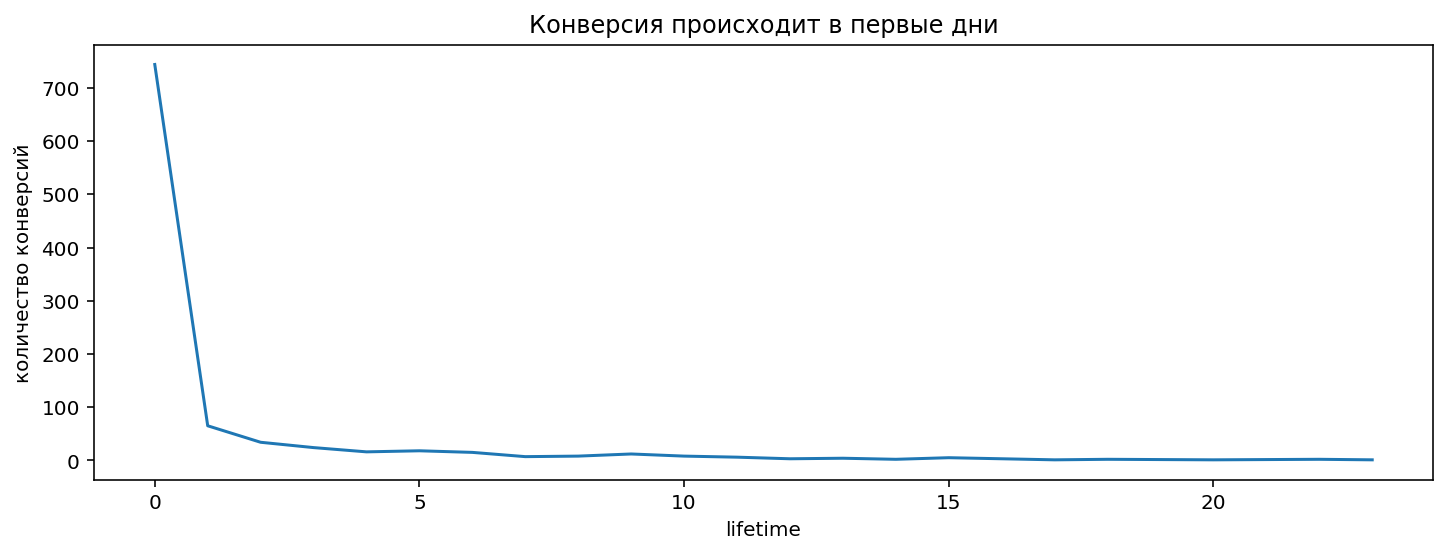

In [110]:
fig, ax = plt.subplots(figsize=(12,4))
profile['conversion_lt'].value_counts().sort_index().plot(ylabel='количество конверсий', xlabel='lifetime')
plt.title('Конверсия происходит в первые дни');

### Сформируем набор данных session
добавим: 
- начало сессии, время и дату 
- длительность сессии, 
- лайфтайм каждой сессии
- признаки клиентов - были ли показаны контакты и источник (для дальнейшего расчета удержания и конверсии в разных разрезах)

In [113]:
session = (
    data
    .groupby(['user_id', 'session_id', 'first_session'], as_index=False)
    .agg(
        session_dt = ('event_time', lambda x:np.min(x).date()),
        session_min = ('event_time', 'min'), 
        session_max = ('event_time', 'max'))
    .assign(
        session_dur = lambda x: (x['session_max'] - x['session_min']).astype("timedelta64[m]"), 
        lifetime = lambda x: (x['session_min'] - x['first_session']).dt.days,
    ).merge(profile, how='left', on='user_id')
)

session.sample(3)

,user_id,session_id,first_session,session_dt,session_min,session_max,session_dur,lifetime,session1_dt,user_opened_contacts,source,contact_show_1st_time,contact_show_1st,conversion_lt
6590,9e3df576-a714-480d-a17c-383a0d3c363b,6591,2019-10-19 10:38:57,2019-10-25,2019-10-25 09:46:37,2019-10-25 09:46:37,0.0,5,2019-10-19,False,yandex,NaT,NaN,NaN
7272,addeebe6-3778-4a6d-8792-02b6dfbf61aa,7273,2019-10-14 14:47:56,2019-10-18,2019-10-18 13:47:41,2019-10-18 14:30:33,42.0,3,2019-10-14,True,yandex,2019-10-14 14:58:59,2019-10-14,0.0
6556,9d2c3d71-c6e8-4957-bc3d-e3a00752519d,6557,2019-10-08 18:52:05,2019-10-11,2019-10-11 20:53:20,2019-10-11 21:06:14,12.0,3,2019-10-08,True,google,2019-10-08 19:01:08,2019-10-08,0.0


#### Проверим длительность получившихся сессий

У нас нет длительности последнего события в сессии, но допущу что им можно пренебречь (учитывая, что оно по определению длится меньше 21 минуты)

90% сессий длятся не дольше 29 минут, 98% сессий не дольше часа. Цифры похожи на реальные. Выбросы есть, но приемлемое количество и диапазон.

In [114]:
session['session_dur'].quantile([i/100 for i in range(70,100,4)])

0.70    12.0
0.74    14.0
0.78    17.0
0.82    20.0
0.86    24.0
0.90    29.0
0.94    38.0
0.98    60.0
Name: session_dur, dtype: float64

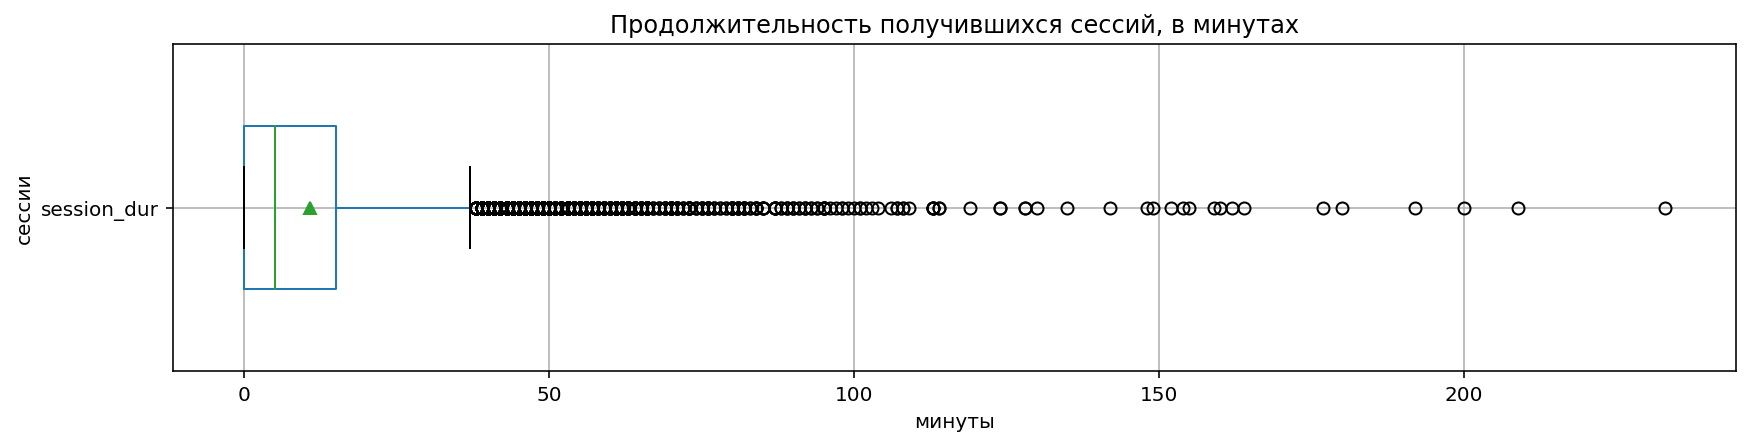

In [115]:
fig, ax = plt.subplots(figsize=(14,3))
session.boxplot('session_dur',  vert=False, showmeans=True, widths=(0.5))
ax.set_xlabel('минуты')
ax.set_ylabel('сессии')
plt.title('Продолжительность получившихся сессий, в минутах');

### Cформируем обогащенный набор действий Sequence

Добавим 
- разметку положения действий относительно целевого действия
- метки совершения целевого действия по клиентам и по сессиям

In [116]:
sequence = (
     data[['user_id', 'session_id', 'event_time', 'event_name']]  
    .assign(is_contacts_show = data['event_name'] == "contacts_show") # разметим событие "contacts_show" в каждой сессии
    .merge(profile[['user_id', 'contact_show_1st_time']], how='left', on='user_id')
)   
# добавлю колонку с подсчетом количества событий 'contacts_show' в сессии
sequence['contacts_show_per_session'] = sequence.groupby('session_id')['is_contacts_show'].transform('sum')
# разметим длительность событий
sequence['delta_sec'] = (
    sequence.groupby('session_id')['event_time'].diff()
    .fillna(pd.Timedelta(minutes=0))
    .astype("timedelta64[s]")
    .astype('int32')
) + 20 #добавлю 20 секунд, чтобы первое событие не было длительностью 0 и его было видно на графике

sequence.head(3)

,user_id,session_id,event_time,event_name,is_contacts_show,contact_show_1st_time,contacts_show_per_session,delta_sec
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:45,tips_show,False,NaT,0,20
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:40:31,tips_show,False,NaT,0,66
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:41:05,tips_show,False,NaT,0,54


добавим 
- время начала сессии
- колонку с временем (в секундах), которое прошло с начала каждой сессии для каждого события

In [117]:
sequence['session_start'] = sequence.groupby('session_id')['event_time'].transform('min')
sequence['from_start'] = (sequence['event_time'] - sequence['session_start']).astype("timedelta64[s]")
sequence.head(3)

,user_id,session_id,event_time,event_name,is_contacts_show,contact_show_1st_time,contacts_show_per_session,delta_sec,session_start,from_start
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:45,tips_show,False,NaT,0,20,2019-10-07 13:39:45,0.0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:40:31,tips_show,False,NaT,0,66,2019-10-07 13:39:45,46.0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:41:05,tips_show,False,NaT,0,54,2019-10-07 13:39:45,80.0


### Выводы

- Набор данных небольшой (73 тысячи записей)
- Пропущенных значений нет
- поле events[event_time] приведем к типу datetime и сократим до секунд, т.к. такая точность достаточна для анализа
- для остальных полей типы корректировать не нужно
- конверсия из tips_show в tips_click - порядка 2%;
- конверсия из contacts show в contacts call - порядка 12%
- В целом количество событий выглядит правдоподобно.
- Медиана favorites_add, contacts_show и contacts_call совпадает
- В tips_show относительно много выбросов.

## Исследовательский анализ данных

Данные охватывают 28 дней

In [118]:
data['event_time'].max() - data['event_time'].min()

Timedelta('27 days 23:58:12')

- конверсия из tips_show в tips_click - порядка 2%;
- конверсия из contacts show в contacts call - порядка 12%
- предположу, что воронка может грубо соответствовать событиям, упорядоченным по количеству

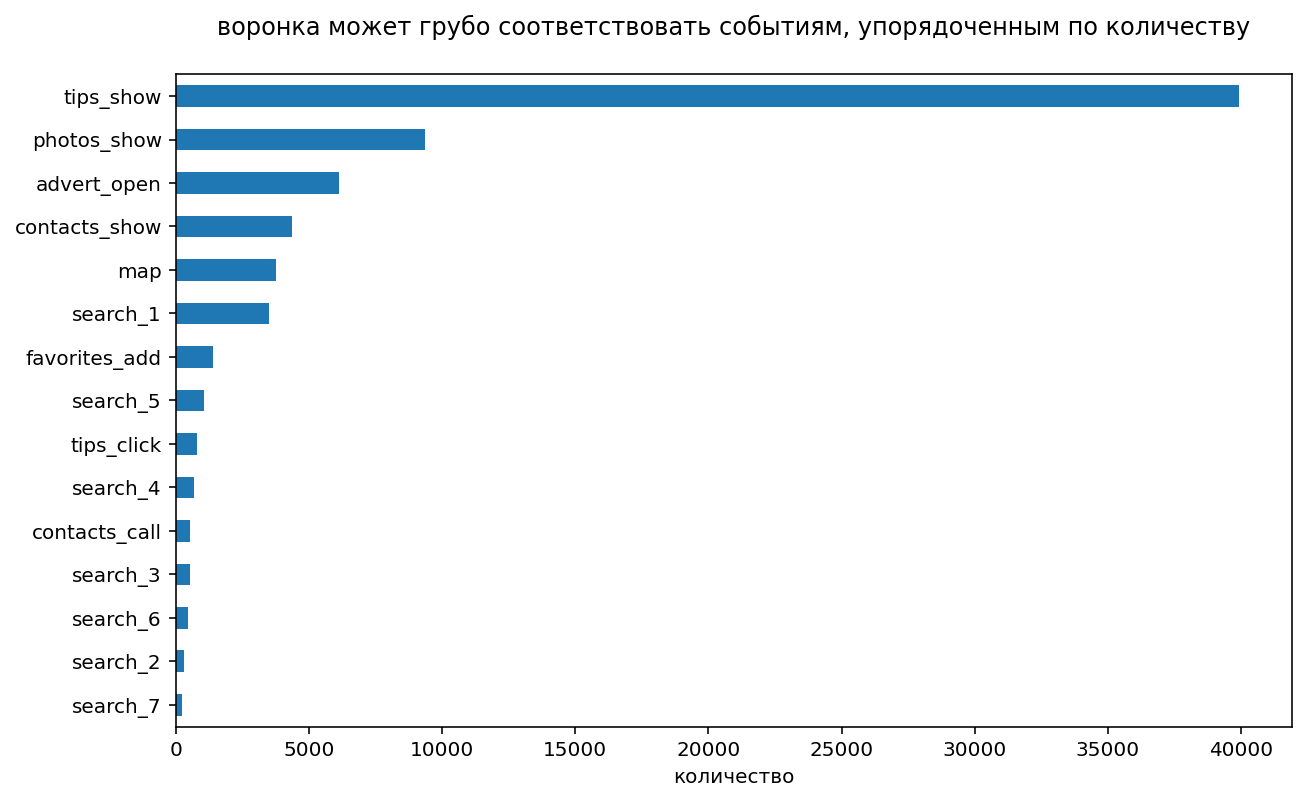

In [119]:
fig, ax = plt.subplots(figsize=(10,6))
data['event_name'].value_counts(ascending=True).plot(kind='barh')
ax.set_xlabel('количество')
plt.title('воронка может грубо соответствовать событиям, упорядоченным по количеству', pad=20);

### Общие характеристики метрик: средние значения, выбросы, распределения   

- Характерную длительность отдельных событий предварительно посмотреть проблематично, т.к. их будут сильно искажать перерывы между сессиями

#### Количество пользователей и действий

- Количество пользователей, распределенных по дням первого действия, небольшое и уменьшается 
- Количество действий коррелирует с количеством новых пользователей в день

In [120]:
u = profile.groupby('session1_dt')['user_id'].count()
print ('В день совершают первое действие в среднем {} человек'.format(u.mean().astype('int')))

В день совершают первое действие в среднем 153 человек


In [121]:
e = (
    events
    .assign(event_dt = events['event_time'].dt.date)
    .groupby('event_dt')['user_id'].count()
)

''

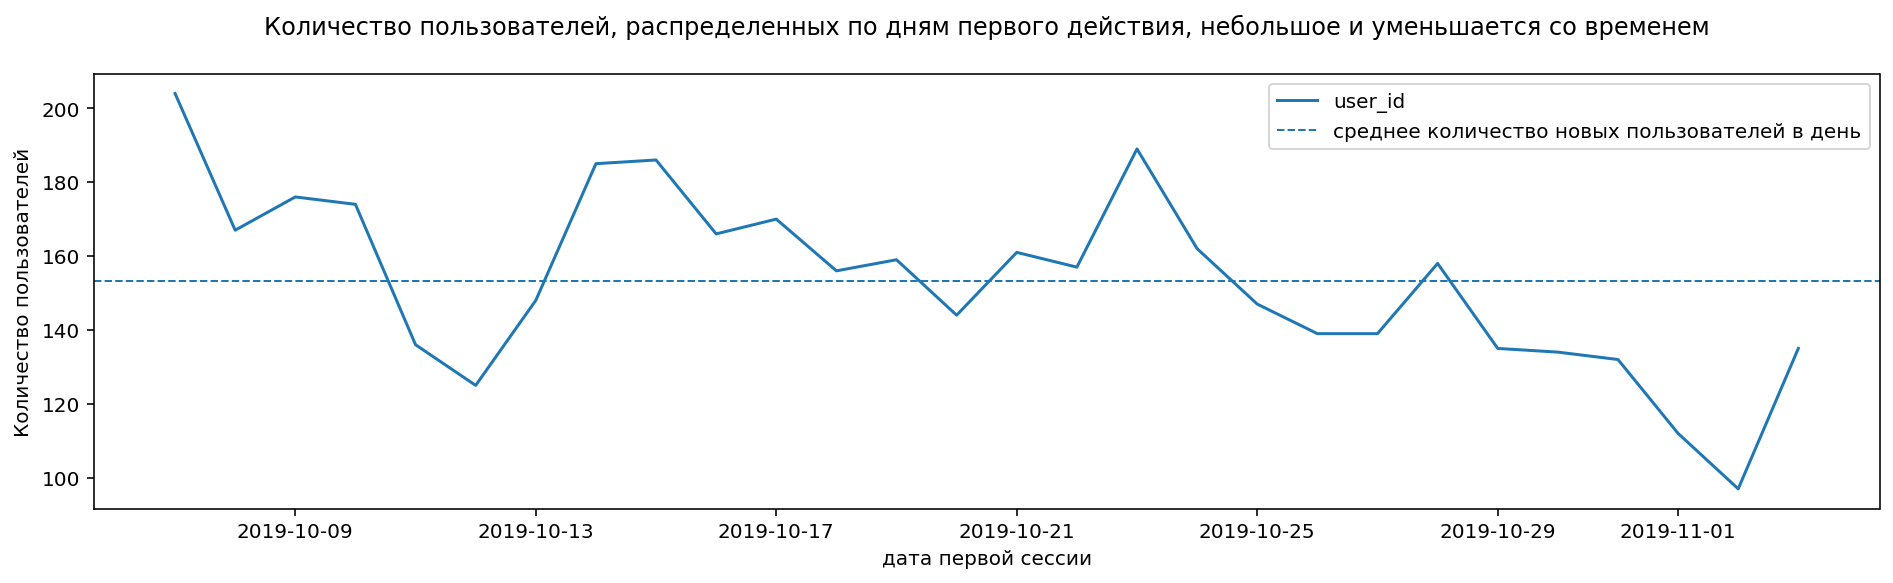

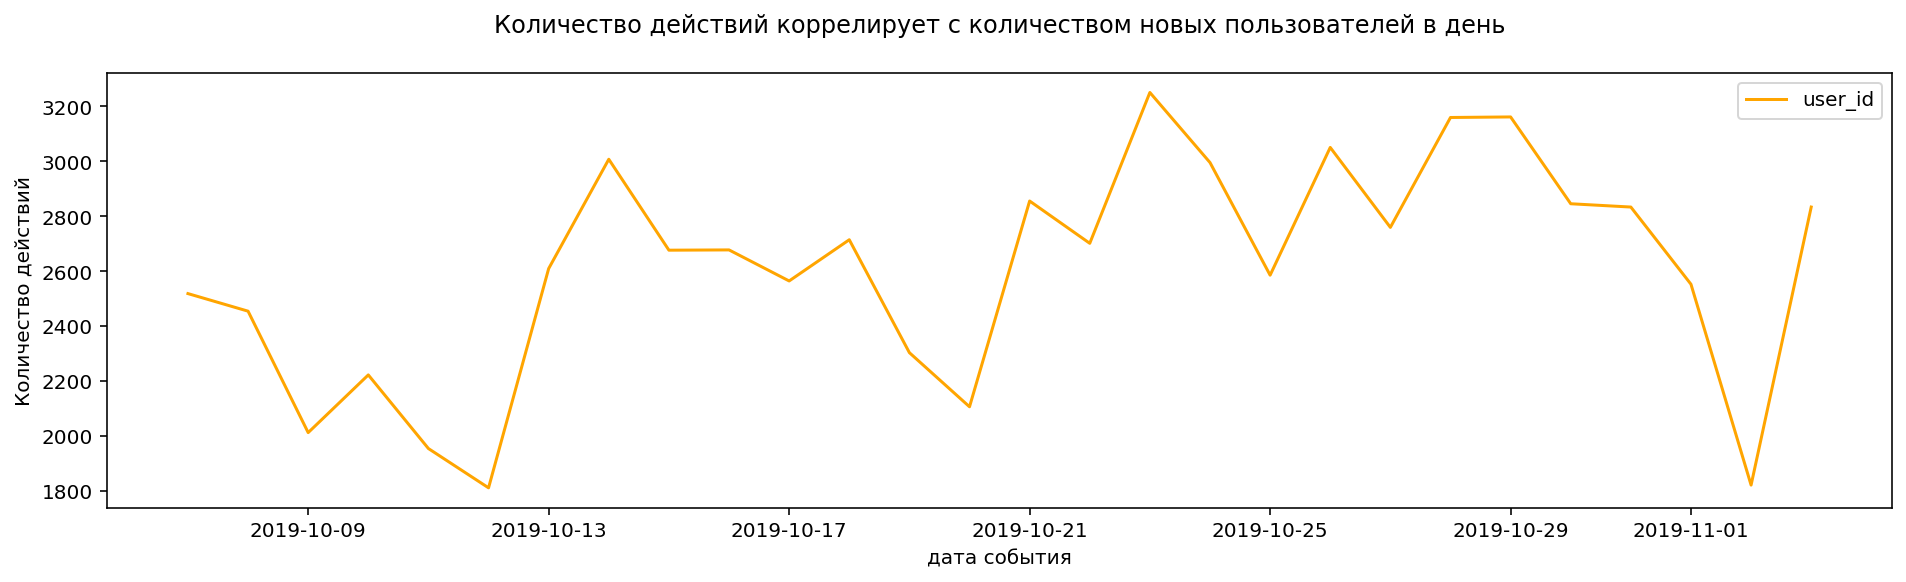

In [122]:
fig, ax = plt.subplots(figsize=(16,4))
u.plot(ylabel='Количество пользователей', xlabel='дата первой сессии')
ax.axhline(y=u.mean(),  
           label='среднее количество новых пользователей в день', linestyle='--', linewidth=1)
plt.legend()
plt.title('Количество пользователей, распределенных по дням первого действия, небольшое и уменьшается со временем', pad=20)
;

fig1, ax1 = plt.subplots(figsize=(16,4))
e.plot(ylabel='Количество действий', xlabel='дата события', color='orange')
plt.legend()
plt.title('Количество действий коррелирует с количеством новых пользователей в день', pad=20)
;

#### количество событий на пользователя

In [123]:
test1 = events.groupby(['user_id', 'event_name'], as_index=False).agg(event_count = ('event_time', 'count'))
test1.head(3)

,user_id,event_name,event_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,6
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,29
2,00157779-810c-4498-9e05-a1e9e3cedf93,advert_open,2


''

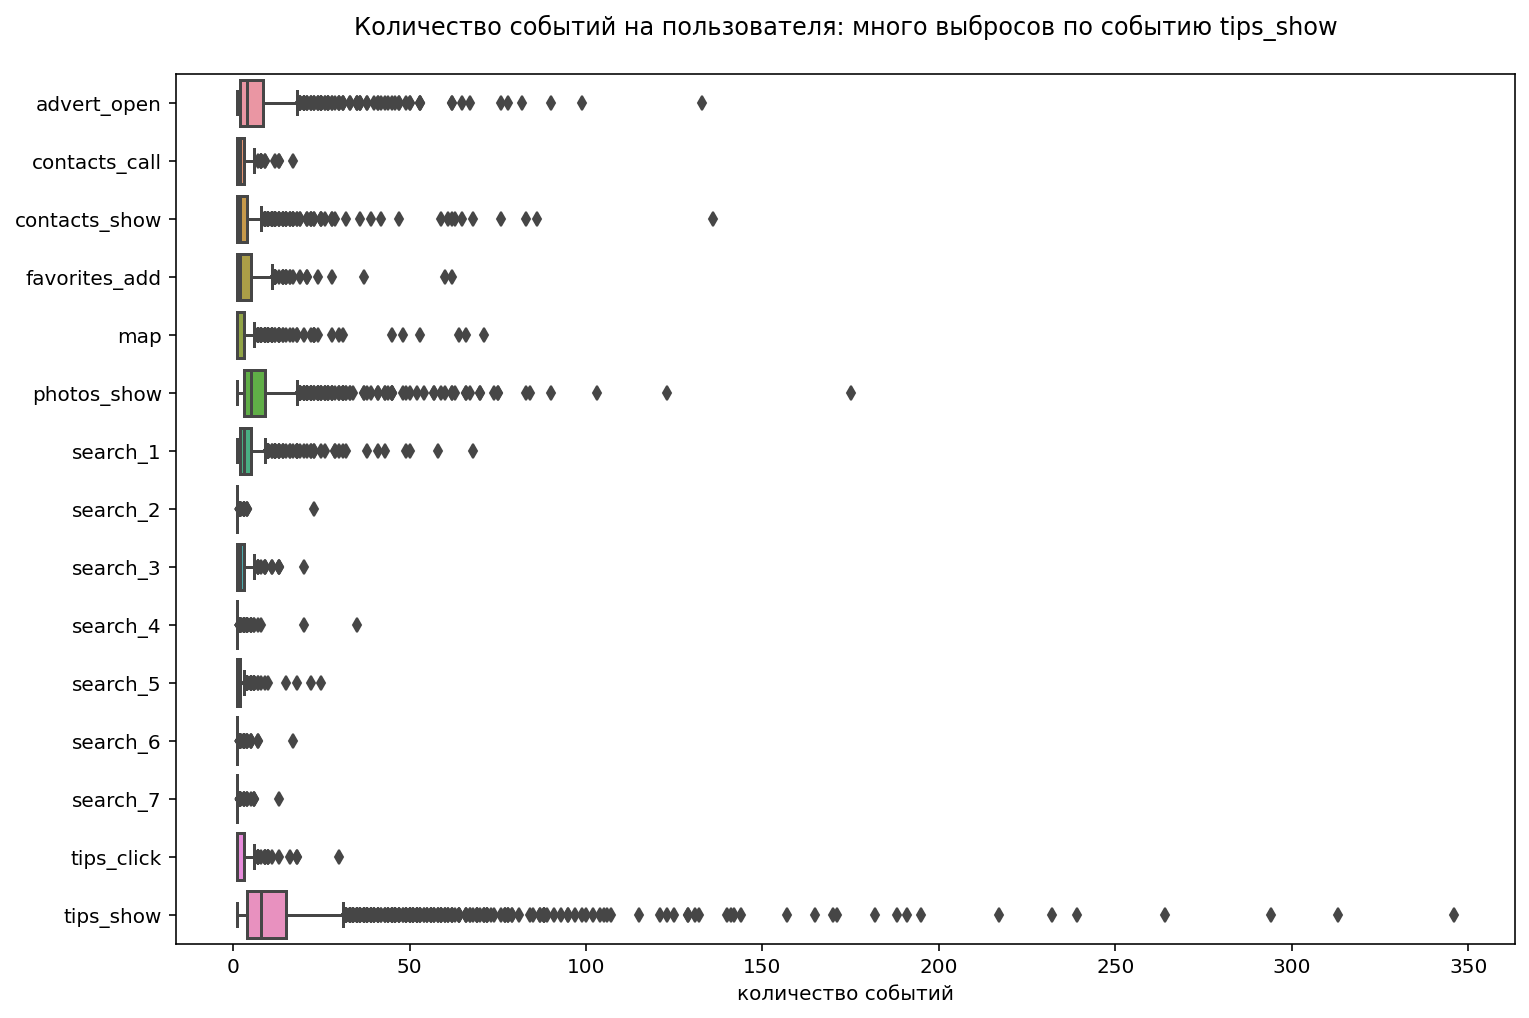

In [124]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.boxplot(y="event_name", x='event_count', data=test1, order=sorted(data['event_name'].unique()))
ax.set_xlabel('количество событий')
ax.set_ylabel('')
plt.title('Количество событий на пользователя: много выбросов по событию tips_show', pad=20)
;

То же самое без выбросов

''

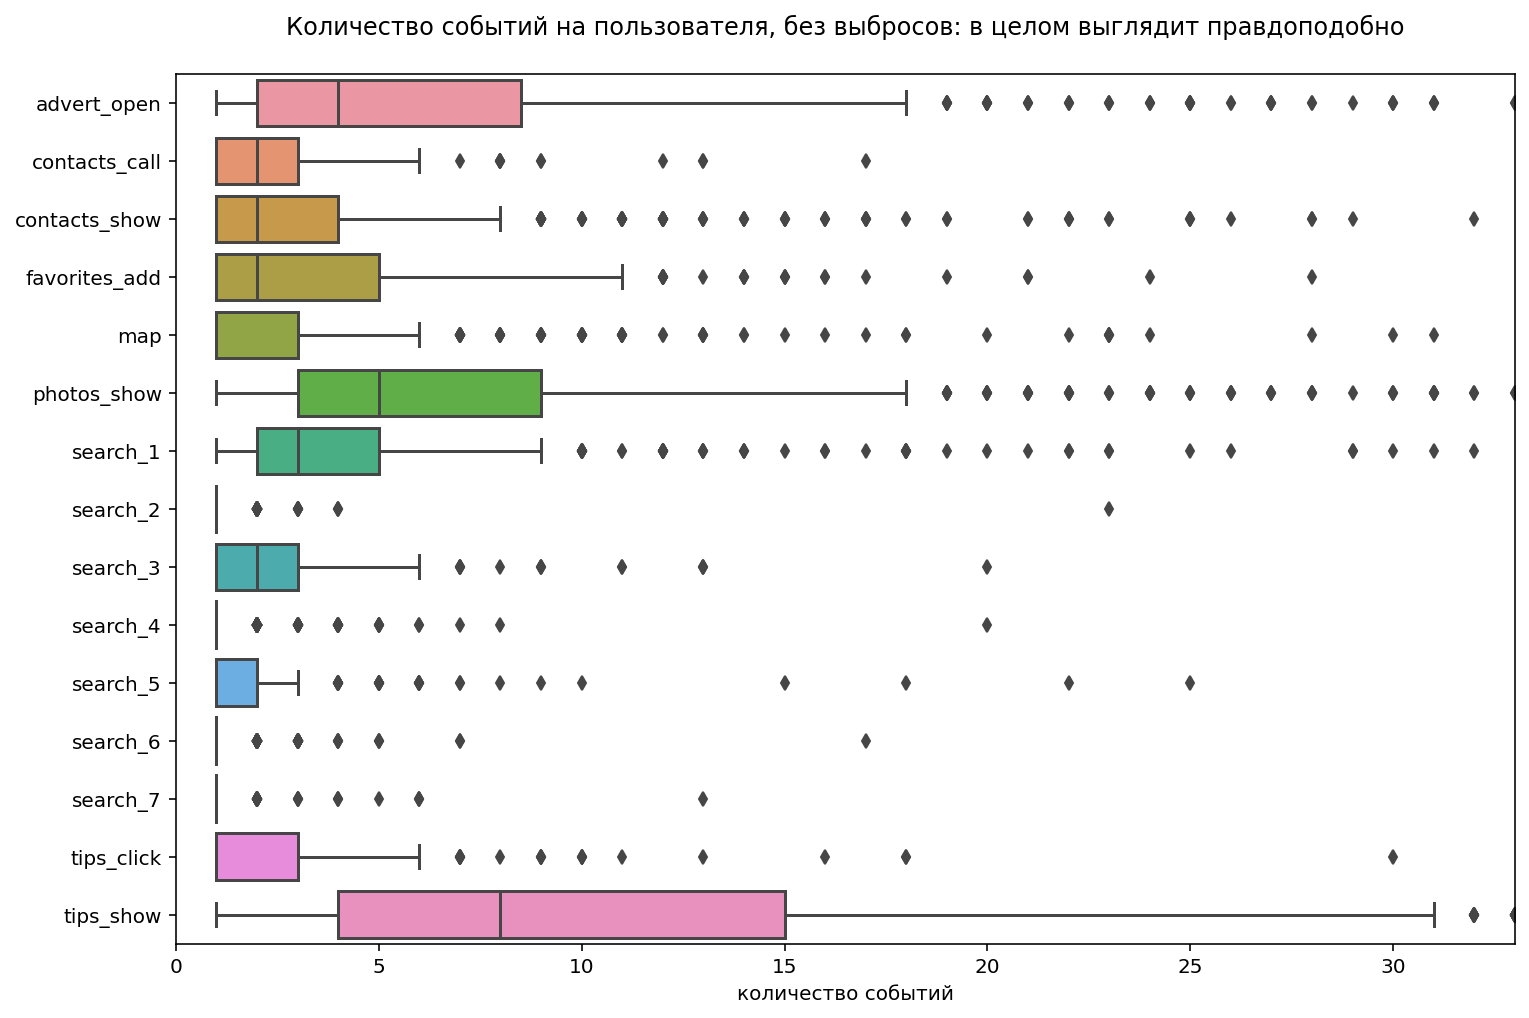

In [125]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(y="event_name", x='event_count', data=test1, order=sorted(data['event_name'].unique()) )
ax.set_xlim(0,33)
ax.set_xlabel('количество событий')
ax.set_ylabel('')
plt.title('Количество событий на пользователя, без выбросов: в целом выглядит правдоподобно', pad=20)
;

- В целом количество событий выглядит правдоподобно.
- Медиана favorites_add, contacts_show и contacts_call совпадает
- В tips_show относительно много выбросов.

Распределение по источникам: Яндекс почти половина, Гугл и остальные - примерно поровну

In [126]:
(
    pd.DataFrame(sources.groupby('source')['user_id'].count())
    .assign (share = lambda x: x / sources.shape[0])
    .sort_values(by='share', ascending=False)
    
)

,user_id,share
source,,
yandex,1934,0.450501
other,1230,0.286513
google,1129,0.262986


#### Выводы

- Набор данных небольшой
- Пропущенных значений нет
- конверсия из tips_show в tips_click - порядка 2%;
- конверсия из contacts show в contacts call - порядка 12%
- В целом количество событий выглядит правдоподобно.
- Медиана favorites_add, contacts_show и contacts_call совпадает
- В tips_show относительно много выбросов.
- предположу что воронка может грубо соответствовать событиям, упорядоченным по количеству
- Распределение по источникам: Яндекс почти половина, Гугл и остальные - поровну

КАЧЕСТВО ДАННЫХ:
- в целом качество данных неплохое, без пропусков / аномалий
- Похоже, для приложения по продаже б/у вещей нужно анализировать более длинные диапазоны.

КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ:
- Новых пользователей немного (порядка 150 в день), и при этом их количество уменьшается. Количество действий в день коррелирует с количеством новых пользователей, что сразу намекает нам, что пользователи не очень часто возвращаются. [меня беспокоит судьба приложения 🥶]

### Retention rate

#### Момент и горизонт анализа

Момент анализа данных задам на последнюю имеющуюся в наборе дату.

Горизонт - 14 дней. 

Похоже, для приложения по продаже б/у вещей нужно анализировать более длинные диапазоны, но у нас всего 28 дней данных. При увеличении диапазона придется отбросить слишком много пользователей.

Определим функцию для расчета удержания

In [127]:
def get_retention (data, dimension, horizon_days=14):
    ''' функция для расчета таблицы удержания
    dimension = признак для группировки '''

    # задаём момент и горизонт анализа данных
    observation_date = events['event_time'].max().date()

    # рассчитываем максимально возможную дату привлечения
    last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    # исключаем пользователей, пришедших после максимальной даты привлечения
    result_raw = data.query('first_session <= @last_suitable_acquisition_date')
    # таблица удержания
    result_grouped = result_raw.pivot_table(
        index=['user_opened_contacts', dimension], columns='lifetime', values='user_id', aggfunc='nunique'
        )
    # делим каждую колонку на размеры когорт 
    result_grouped = result_grouped.div(result_grouped[0], axis=0)
    # исключаем из результата все лайфтаймы, превышающие горизонт анализа и нулевой лайфтайм
    result_grouped = result_grouped[list(range(1, horizon_days))]

    return result_grouped

#### Кривые удержания

Определим функцию для визуализации удержания по произвольным когортам

In [128]:
def plot_retention_curve(data): 
        
    fig, axlist = plt.subplots(1,2,sharey=True, figsize=(20,6))

    for i in [0,1]:
        y = 'True' if i==1 else 'False'
        data.loc[i].T.plot(
            grid=True,
            xticks=list(data.columns.values),
            ax=axlist[i],
            title = ("Показ контактов = "+y), xlabel = 'Лайфтайм'
        )

    plt.suptitle('Кривые удержания по дням привлечения')
    plt.show()

Построим кривые удержания по дням привлечения с разбивкой по дате когорты

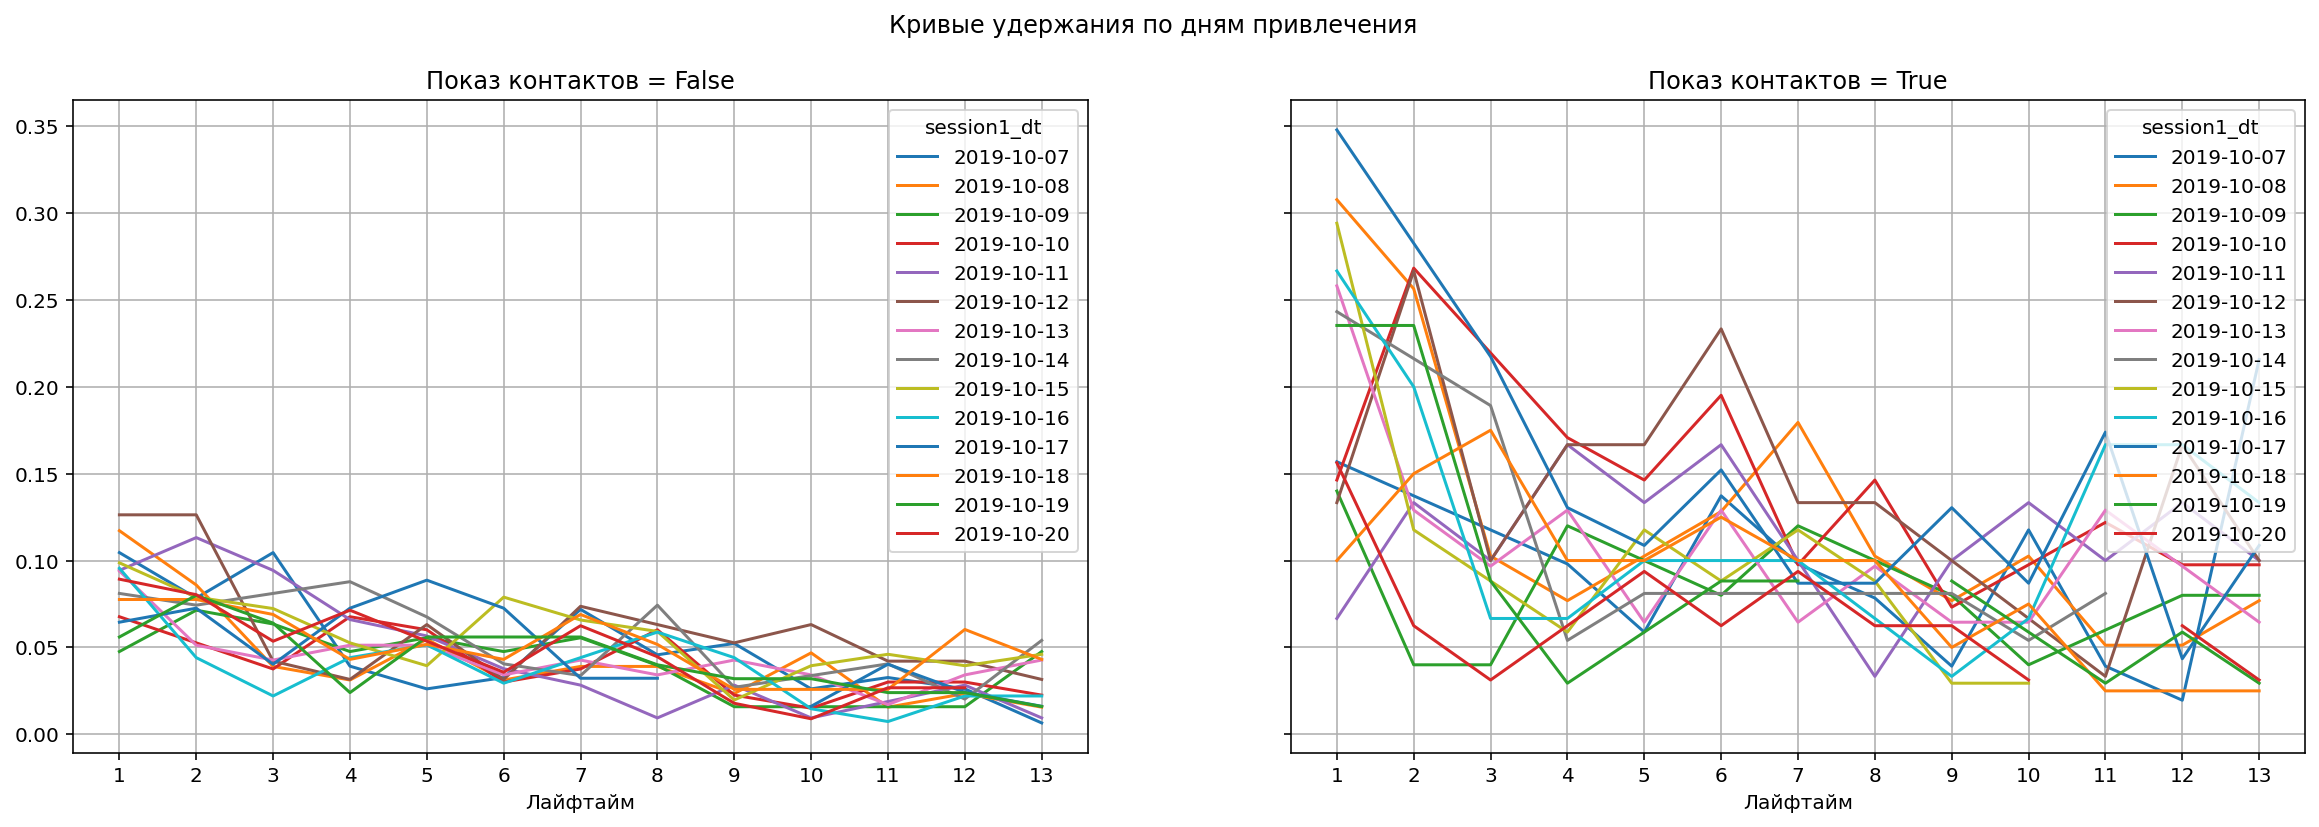

In [129]:
plot_retention_curve(get_retention(data=session, dimension='session1_dt'))

Построим кривые удержания по дням привлечения с разбивкой по признаку **источник**

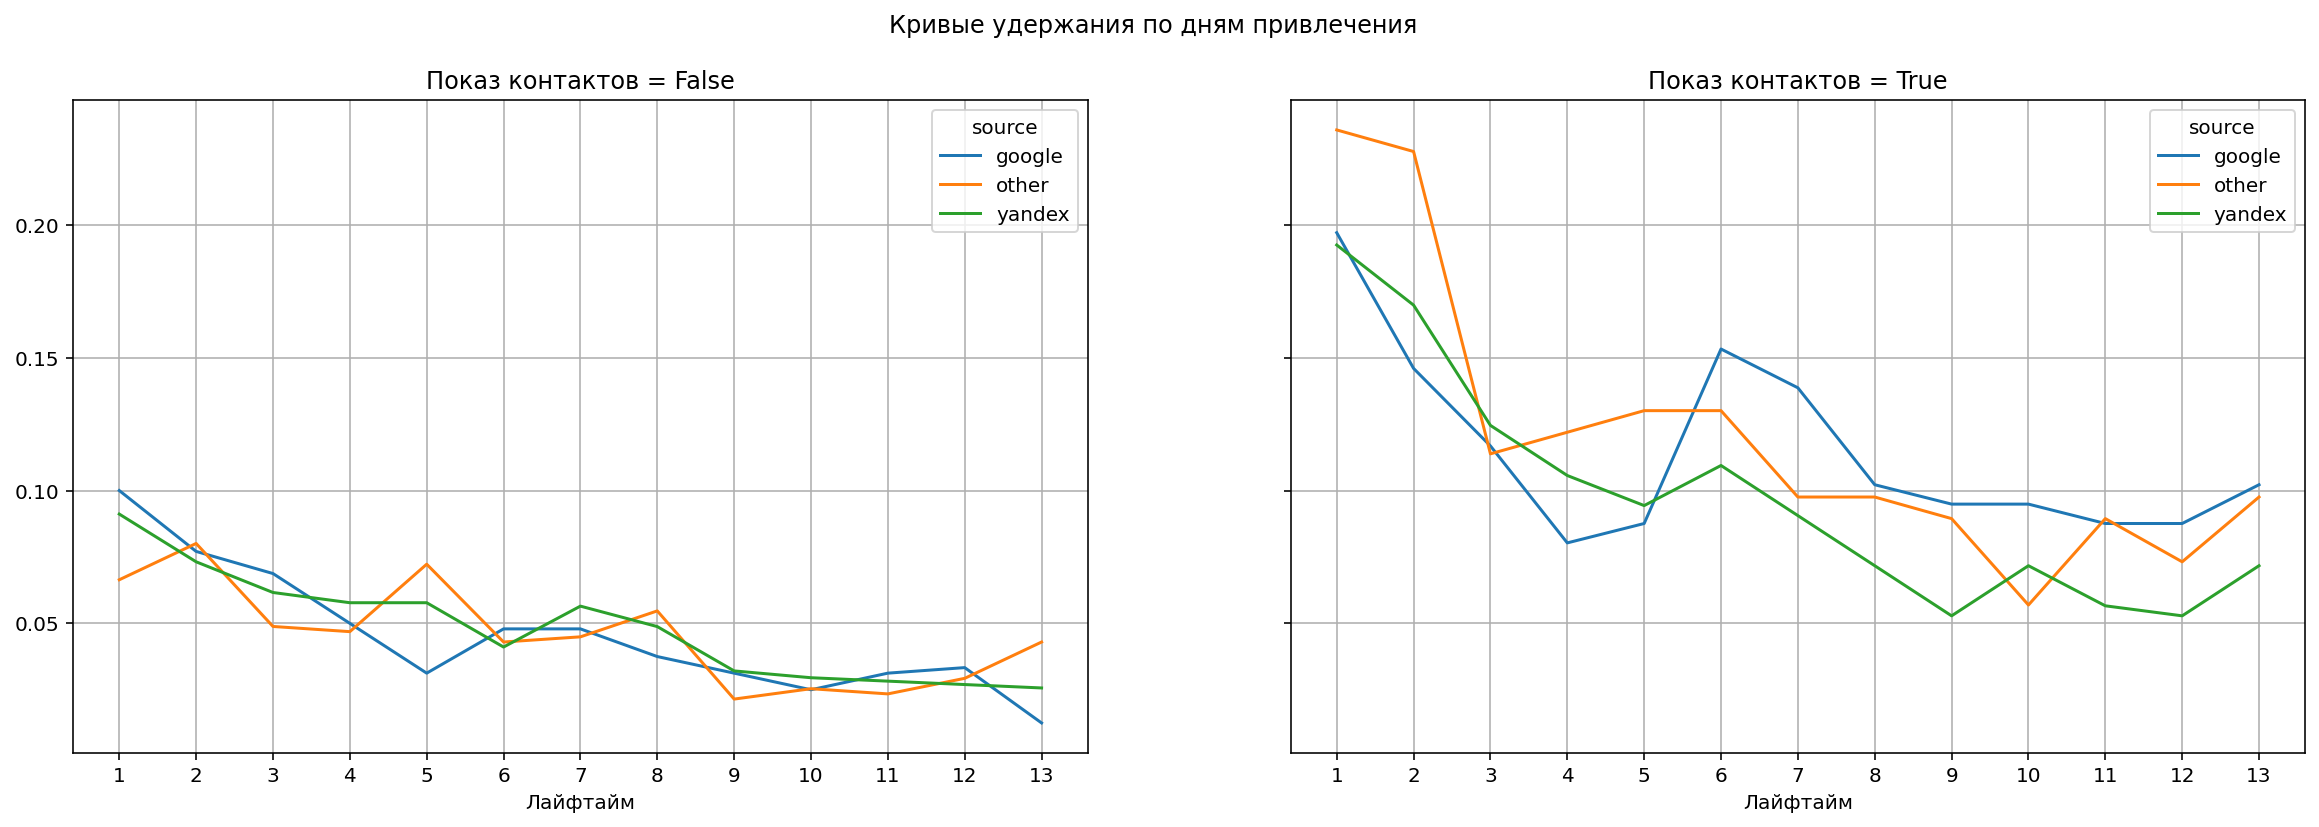

In [130]:
plot_retention_curve(get_retention(data=session, dimension='source'))

#### Удержание в динамике

Определим функцию для визуализации динамики удержания

In [131]:
def plot_retention_dynamics(data): 
        
    fig, axlist = plt.subplots(1,2,sharey=True, figsize=(20,6))

    for i in [0,1]:
        y = 'True' if i==1 else 'False'
        data.loc[i].plot(
            grid=True,
            ax=axlist[i],
            title = ("Показ контактов = "+y), xlabel = 'Критерий'
        )

    plt.suptitle('Динамика удержания пользователей')
    plt.show()

Построим график динамики удержания пользователей с разбивкой по дате когорты

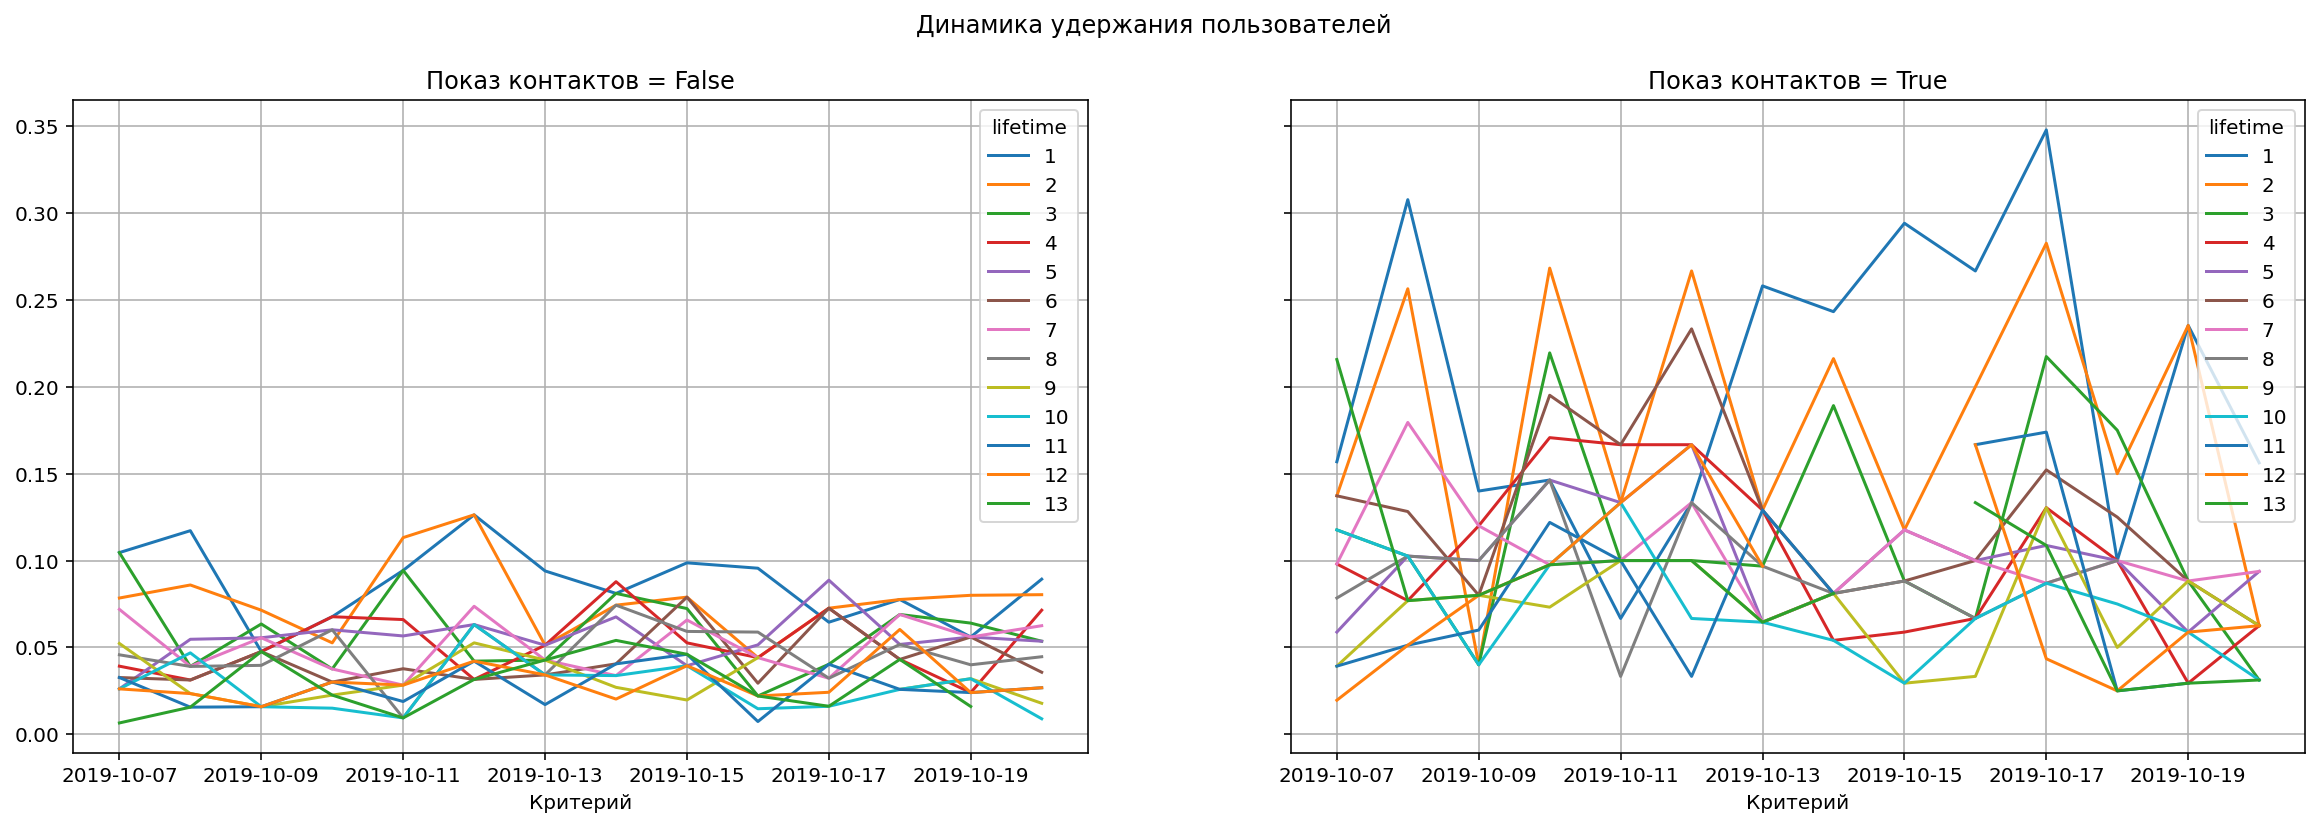

In [132]:
plot_retention_dynamics(get_retention(data=session, dimension='session1_dt'))

Построим график динамики удержания пользователей с разбивкой по источнику

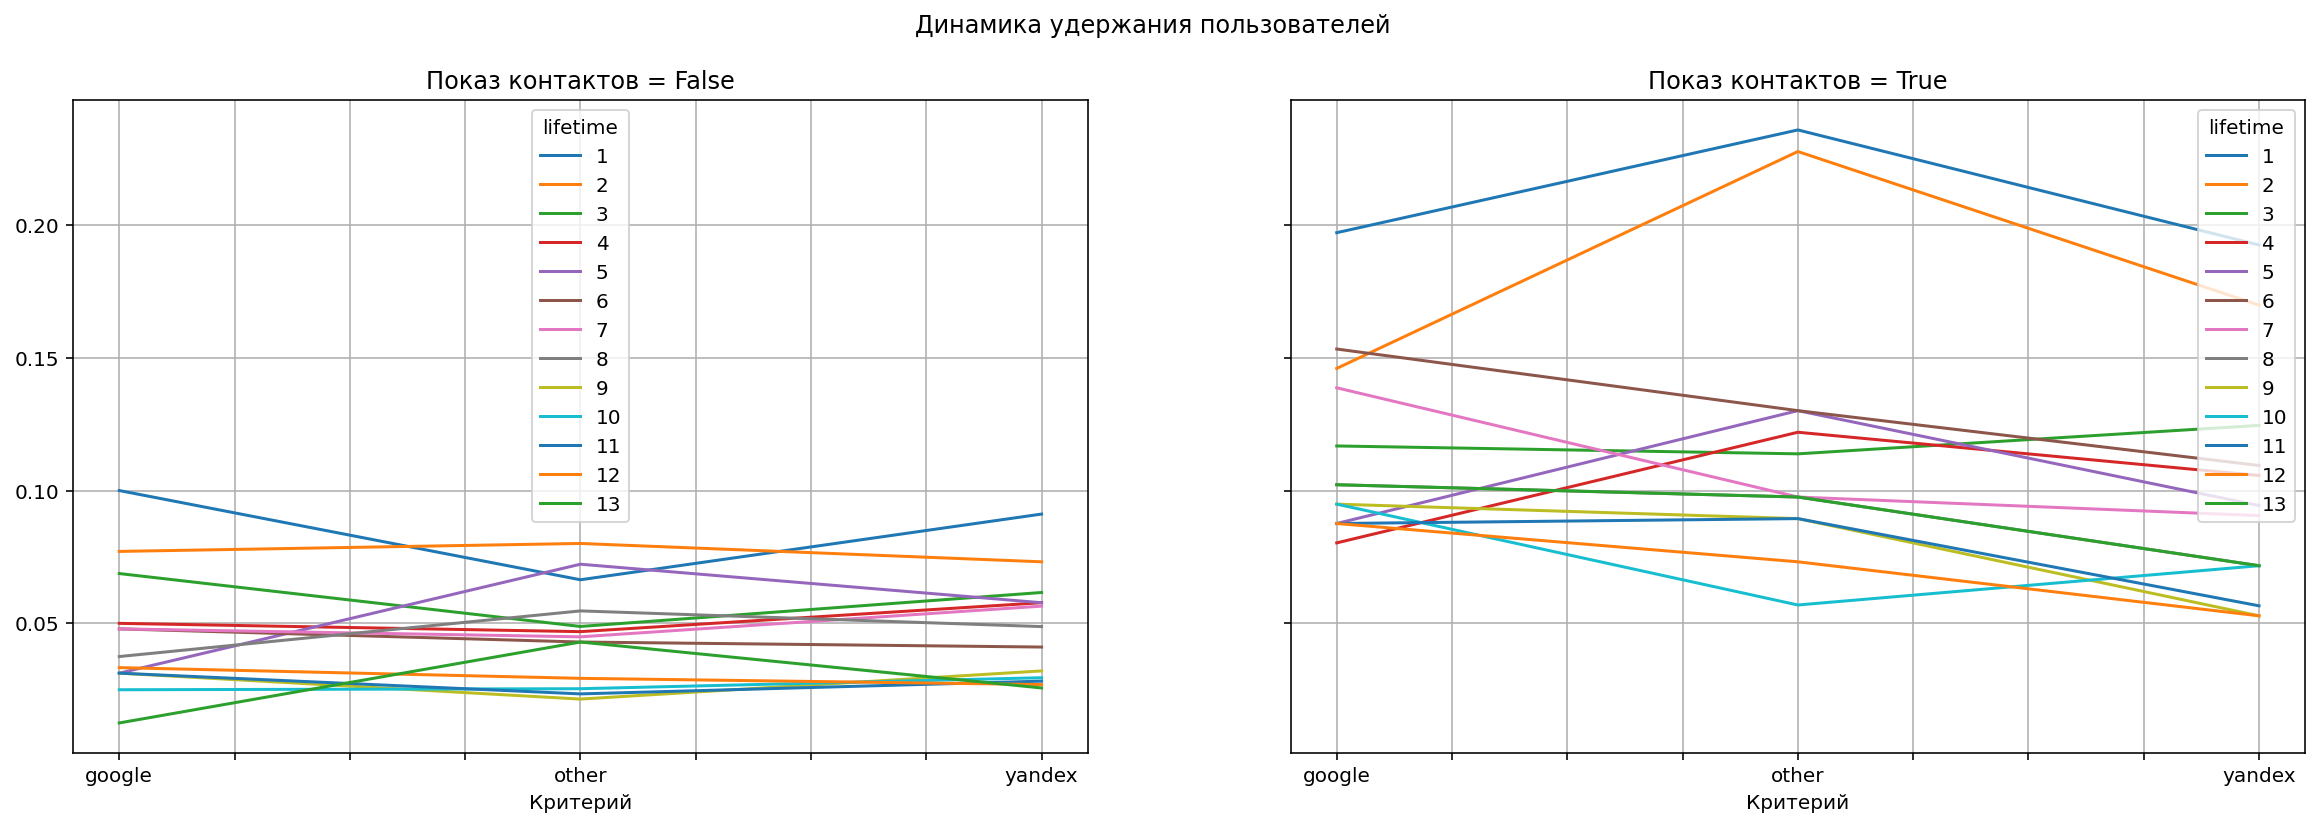

In [133]:
plot_retention_dynamics(get_retention(data=session, dimension='source'))

#### Вывод: 
- удержание существенно выше для клиентов, которые смотрели контакты
- не видно существенной разницы по дате когорты
- не видно существенной разницы по источнику привлечения
- предположу, что для приложения, в котором пользователи продают / покупают вещи может иметь смысл рассматривать более длинный временной промежуток для анализа удержания (пользователи могут возвращаться раз в месяц или даже реже)

### DAU, MAU

In [134]:
data['event_date']=data['event_time'].dt.date
data.sample(5)

,event_time,event_name,user_id,delta_sec,session_id,first_session,event_date
1722,2019-10-07 20:01:23,tips_show,f6d32706-cdf0-48b1-a419-fdbecc4235f7,29,10449,2019-10-07 19:27:32,2019-10-07
65932,2019-10-31 17:46:27,contacts_show,8e3e5cc1-ac68-47e1-846f-89f4fb7326f5,135,5982,2019-10-30 14:49:27,2019-10-31
2510,2019-10-07 23:46:55,tips_show,97254524-9a2e-4f7b-9190-3cc0f50ab19c,100,6258,2019-10-07 18:39:34,2019-10-07
20031,2019-10-15 15:04:03,map,9b835c74-8ede-4586-9f59-e5473aa48de2,1875,6443,2019-10-07 14:21:11,2019-10-15
6270,2019-10-09 16:08:48,tips_show,c83d8f7c-3b43-495c-94db-3aac32dbed98,147,8426,2019-10-09 15:44:23,2019-10-09


''

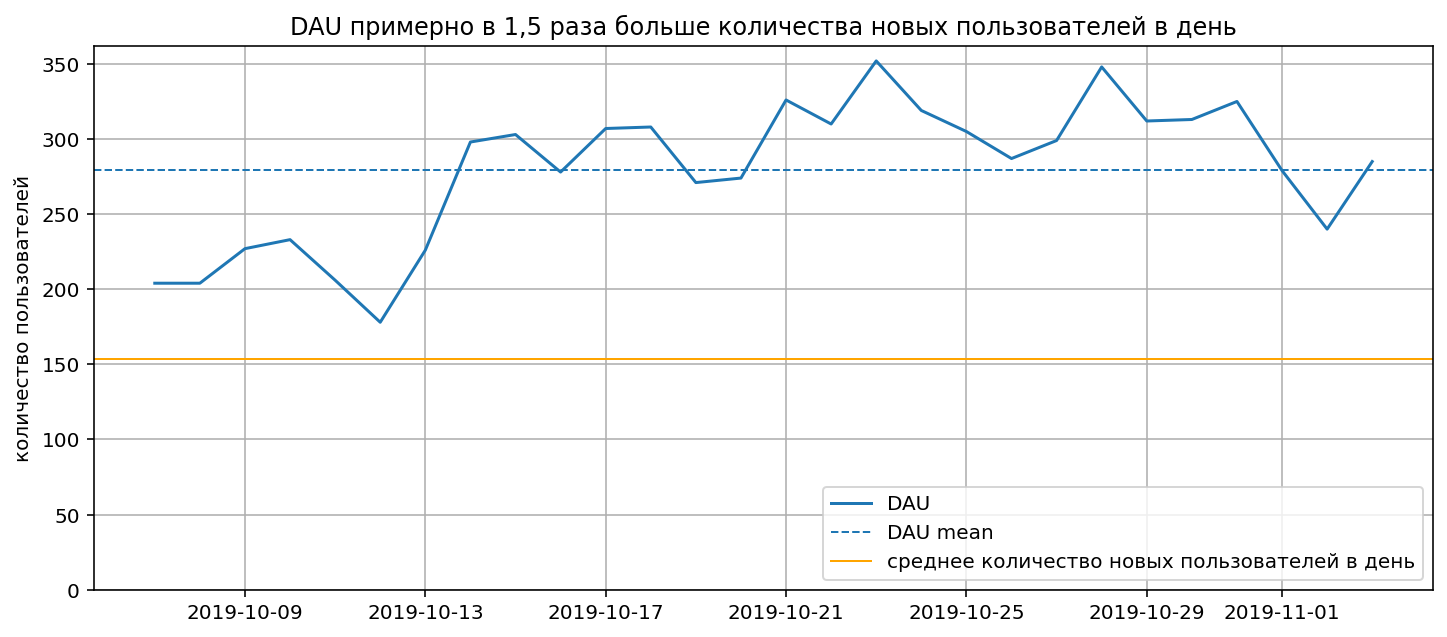

In [135]:
dau = data.groupby('event_date')['user_id'].nunique()

fig, ax = plt.subplots(figsize=(12,5))
dau.plot(grid=True, label='DAU')
ax.axhline(y=dau.mean(), label='DAU mean', linestyle='--', linewidth=1)
ax.axhline(y=u.mean(), label='среднее количество новых пользователей в день', linewidth=1, color='orange')
ax.set_xlabel('')
ax.set_ylabel('количество пользователей')
plt.ylim(0,)
plt.legend(loc='lower right')
plt.title('DAU примерно в 1,5 раза больше количества новых пользователей в день')
;

#### Вывод: 

DAU
- Daily Active Users немного (175 - 350). Это примерно в полтора раза больше, чем новых пользователей. 
- Надеюсь что мы работаем с частичной выборкой. Если это самое начало развития сервиса - было бы логично видеть более активную динамику роста. 

RETENTION
- удержание существенно выше для клиентов, которые смотрели контакты
- не видно существенной разницы по дате когорты
- не видно существенной разницы по источнику привлечения
- предположу, что для приложения, в котором пользователи продают / покупают вещи может иметь смысл рассматривать более длинный временной промежуток для анализа удержания (пользователи могут возвращаться раз в месяц или даже реже)


НЕОБХОДИМО ИССЛЕДОВАТЬ: 

Если пользователи возвращаются редко - возможно, они в основном продают вещи через приложение.
Соответственно, потенциал к развитию может быть в том, чтобы продавцы начали рассматривать приложение как платформу не только для продажи, но и для покупок

### Конверсия

Определим функцию для расчета конверсии, в том числе с учетом дополнительных параметров

In [136]:
def get_convertion (data, dimension, horizon_days=14):
    ''' функция для расчета конверсии
    dimension = признак для группировки '''
    # задаём момент и горизонт анализа данных
    observation_date = events['event_time'].max().date()
    # рассчитываем максимально возможную дату привлечения
    last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    # исключаем пользователей, пришедших после максимальной даты привлечения
    result_raw = profile.query('session1_dt <= @last_suitable_acquisition_date')
    
    # находим размеры когорт
    cohort_size = (
        result_raw.groupby(dimension)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    # таблица конверсии
    result = (
        result_raw
        .pivot_table(index=[dimension], columns='conversion_lt', values='user_id', aggfunc='nunique')
        .fillna(0).cumsum(axis = 1)
        .merge(cohort_size, on=dimension, how='left').fillna(0)
    )
    # делим каждую колонку на размеры когорт 
    result = result.div(result['cohort_size'], axis=0)
    # исключаем из результата все лайфтаймы, превышающие горизонт анализа и нулевой лайфтайм
    result = result[list(range(0, horizon_days))]

    return result

Построим график конверсии с разбивкой по источникам

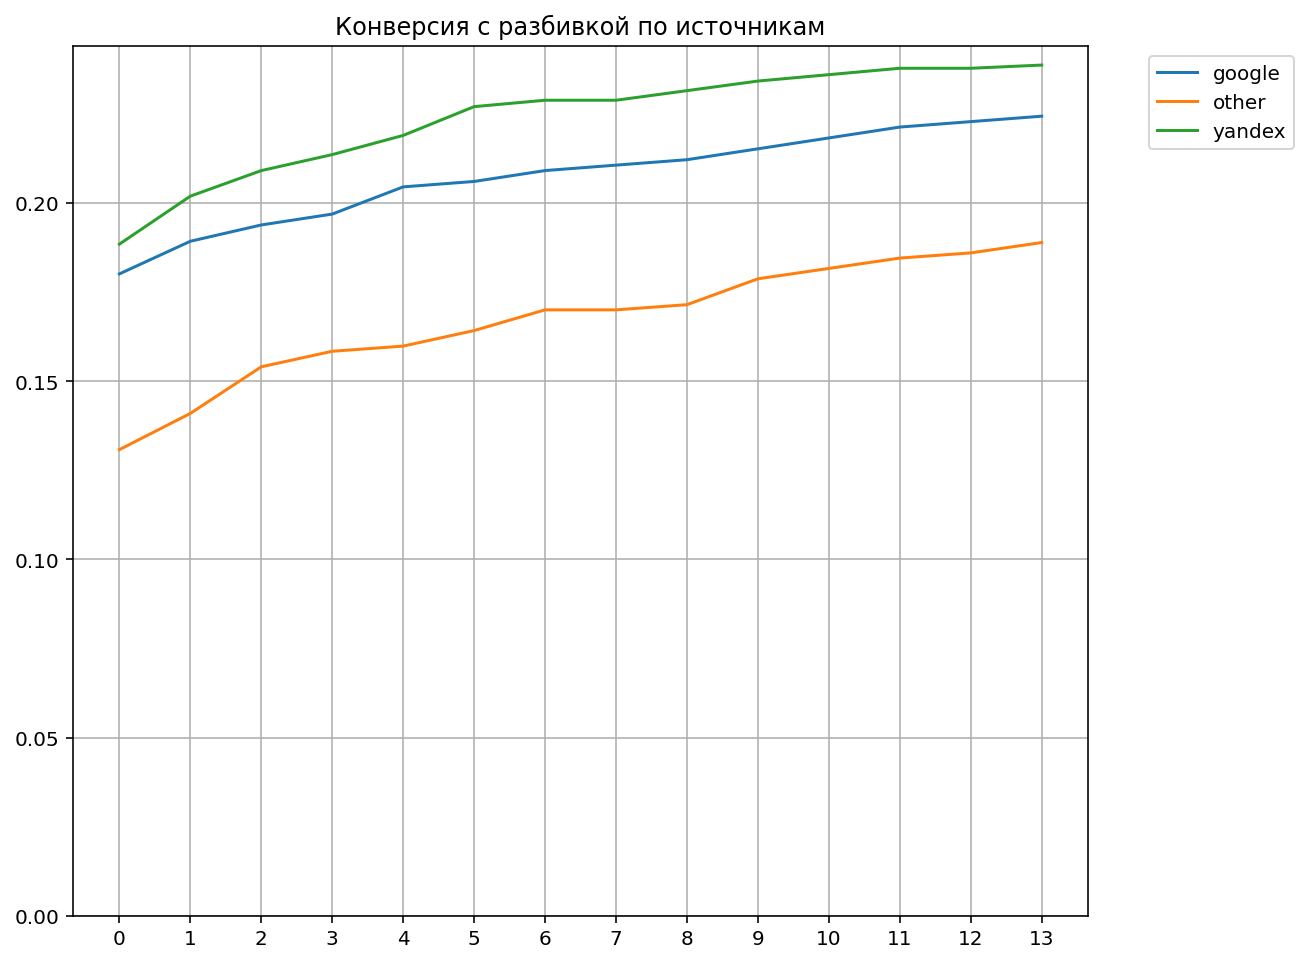

In [144]:
report = get_convertion(data, 'source')

plt.figure(figsize=(20, 8))
report.T.plot(grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1))
ax.set_xlabel('лайфтайм')
ax.set_ylabel('конверсия')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylim(0,)
plt.title('Конверсия с разбивкой по источникам');

#### Вывод: конверсия стабильно отличается по источникам: 

Лучший результат - Yandex, 

следующий - Google, 

на третьем месте - остальные источники

### Выясним, какие действия совпадают с просмотром контактов  

#### В общем наборе данных четкой линейной корреляции между событием "показ контактов" и другим событием не наблюдается

есть сильная корреляция между 'contacts_show' и 'contacts_call', но это объяснить просто: для того чтобы позвонить нужно сначала открыть контакты. Анализировать тут нечего )

In [47]:
actions = (
    data
    .pivot_table(index='session_id', columns='event_name', values='user_id', aggfunc='count')
#     .fillna(0)  
)

actions['search'] = actions[['search_1', 'search_2', 'search_3', 'search_4',
       'search_5', 'search_6', 'search_7']].sum(axis=1)
actions.drop (columns=['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7'], inplace=True)

actions.sample(5)

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,tips_click,tips_show,search
session_id,,,,,,,,,
9588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
7972,NaN,NaN,NaN,NaN,1.0,NaN,NaN,11.0,0.0
5523,12.0,NaN,NaN,NaN,1.0,NaN,NaN,12.0,0.0
1049,NaN,NaN,NaN,NaN,1.0,NaN,1.0,12.0,0.0
8771,NaN,NaN,4.0,NaN,NaN,7.0,NaN,NaN,4.0


''

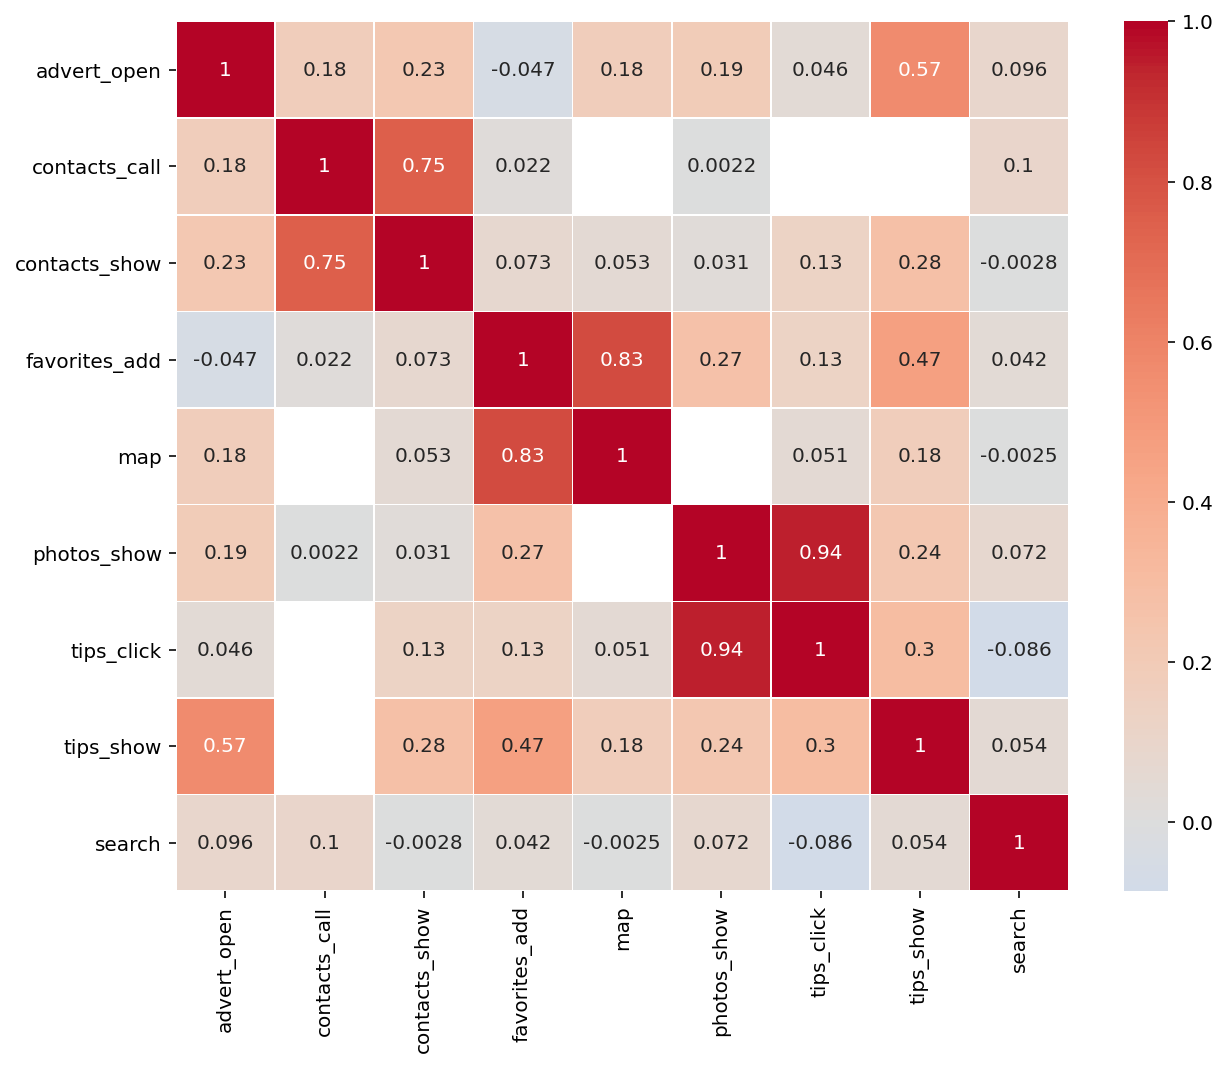

In [48]:
correlation = actions.corr()

fig, ax = plt.subplots(figsize=(10,8))
# plt.title("Корреляция между основными показателями по оттоку клиентов для фитнес-центра")
sns.heatmap(correlation, linewidths=.3, annot=True, ax=ax, cmap="coolwarm", center=0)
ax.set_xlabel('')
ax.set_ylabel('')
;

#### 77% пользователей ни разу не открывали контакты

In [49]:
print ('сколько раз пользователь открывал контакты, доля (топ-5 значений):')

s1 = (
    sequence
    .groupby(['user_id', 'session_id'], as_index=False)['contacts_show_per_session'].mean()
    .groupby('user_id')['contacts_show_per_session'].sum()   
)

display (s1.value_counts(normalize=True).head(5))

display (s1.value_counts().head(5))

сколько раз пользователь открывал контакты, доля (топ-5 значений):


0    0.771488
1    0.088516
2    0.043093
3    0.024691
4    0.016306
Name: contacts_show_per_session, dtype: float64

0    3312
1     380
2     185
3     106
4      70
Name: contacts_show_per_session, dtype: int64

Добавим признаки: 
- "действие состоялось ДО первого показа контактов. Это позволит посмотреть, как отличается набор действий ДО показа контактов от действий ПОСЛЕ
- подсчет количества раз, которые пользователь открывал контакты (чтобы можно было проанализировать отдельно пользователей, которые открывали контакты ровно 1 раз) и выявить события, которые чаще случаются ДО или ПОЗЖЕ

In [50]:
sequence['user_opened_contacts'] = sequence.groupby('user_id')['is_contacts_show'].transform('sum') > 0
sequence['before_contacts'] = sequence.groupby('user_id')['is_contacts_show'].transform('cumsum') < 1
sequence['user_opened_contacts_count'] = sequence.groupby('user_id')['is_contacts_show'].transform('sum')
sequence.sample(5)

,user_id,session_id,event_time,event_name,is_contacts_show,contact_show_1st_time,contacts_show_per_session,delta_sec,session_start,from_start,user_opened_contacts,before_contacts,user_opened_contacts_count
46565,a7ba0732-334d-4370-aff5-6acec2adec18,6975,2019-10-20 00:36:50,photos_show,False,NaT,0,45,2019-10-20 00:30:08,402.0,False,True,0
21043,49681f61-edb4-40ad-89fa-baaa43867539,3157,2019-10-19 16:36:18,contacts_call,False,2019-10-09 18:35:26,2,22,2019-10-19 16:28:22,476.0,True,False,6
4682,0eb4f4c9-d8be-4630-8ca0-bdac8bad6d18,673,2019-10-15 18:55:31,contacts_show,True,2019-10-15 18:36:37,8,391,2019-10-15 18:36:37,1134.0,True,False,8
25582,5da6f553-9943-4a2c-940f-9ee7f292e438,3862,2019-10-17 14:31:22,tips_show,False,NaT,0,90,2019-10-17 14:24:16,426.0,False,True,0
67818,ebff6a7d-8e7e-4a88-9fb8-bcdd3476c6f5,10065,2019-10-29 16:31:11,tips_show,False,NaT,0,27,2019-10-29 16:09:05,1326.0,False,True,0


Визуализируем долю ВСЕХ событий в разбивке по количеству показов контактов в сессии

In [51]:
d1 = (
    sequence.query('contacts_show_per_session <5')
    .groupby(['contacts_show_per_session', 'event_name'], as_index=False)     
    .agg(
    count=('user_id', 'count'),       
    )
    .assign(base = lambda x: x.groupby('contacts_show_per_session')['count'].transform('sum'))
    # поделим количество событий в категории на общее количество событий, чтобы получить долю событий
    .assign(frequency = lambda x: x['count'] / x['base'])
)  
d1.sample(1)

,contacts_show_per_session,event_name,count,base,frequency
41,2,tips_click,32,2860,0.011189


''

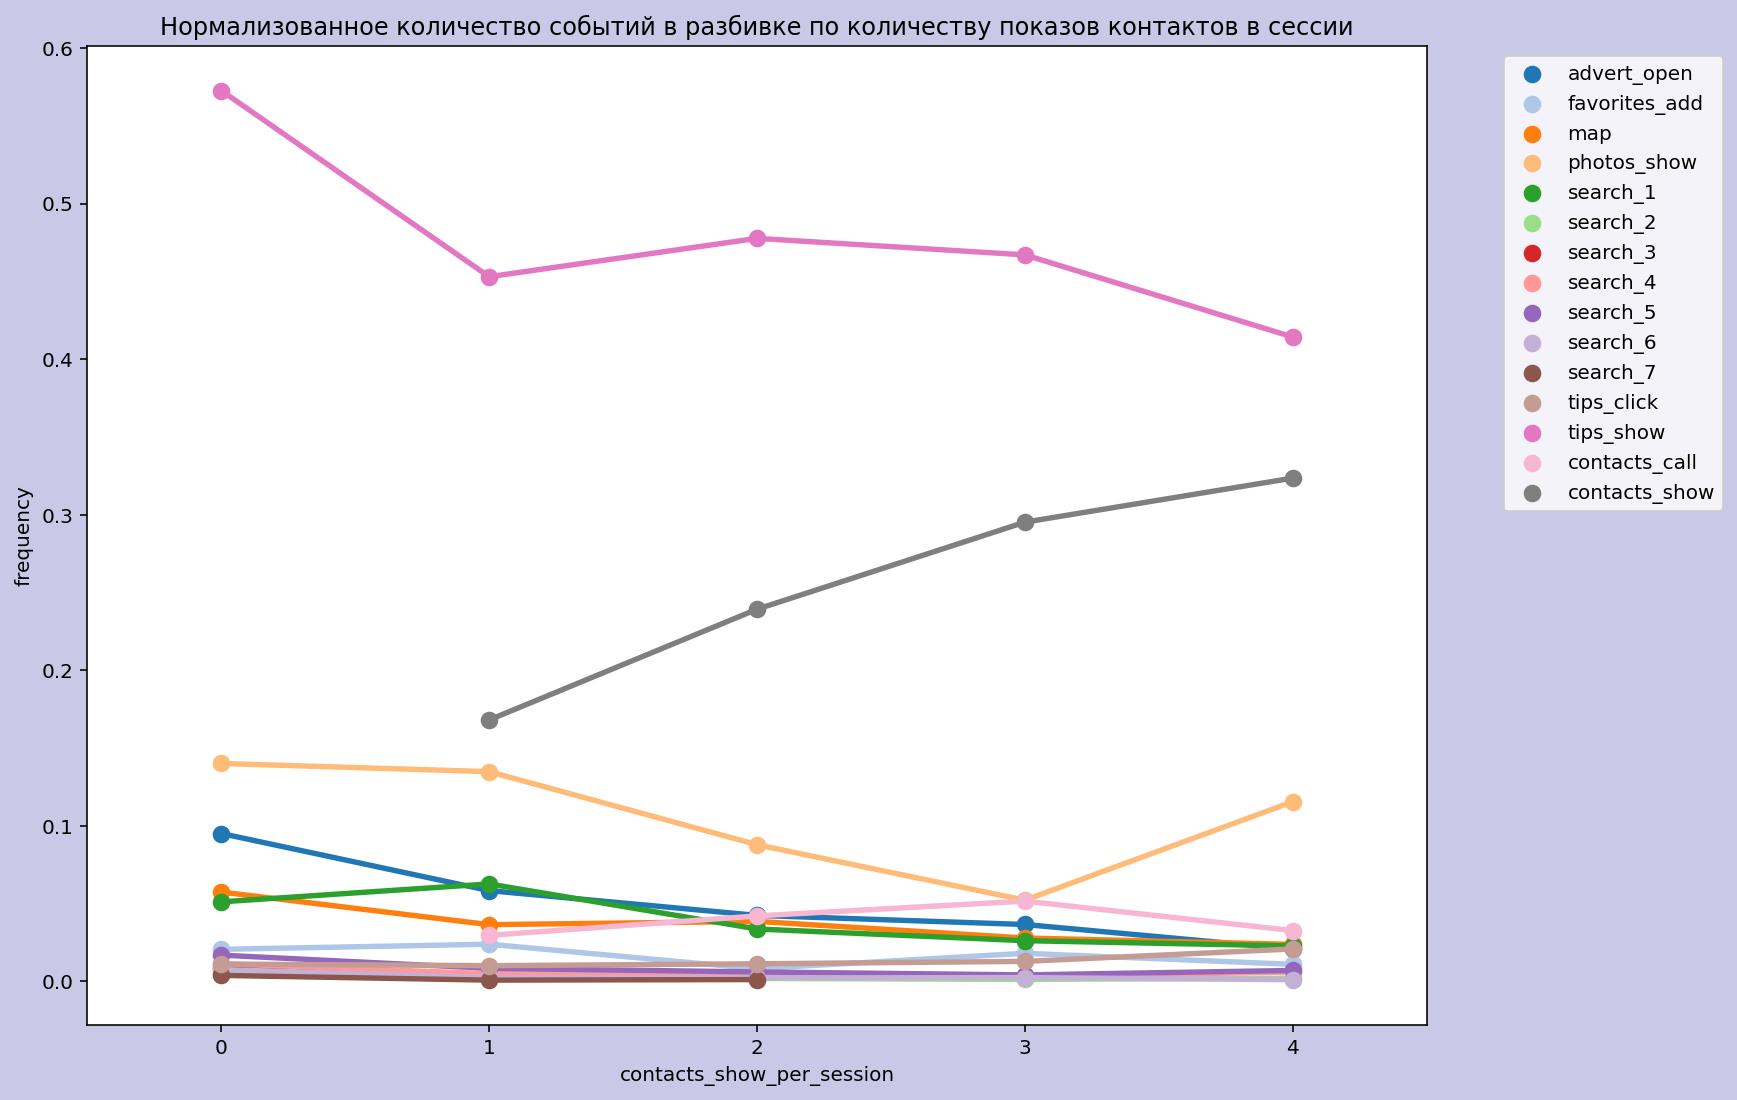

In [52]:
fig, ax = plt.subplots(figsize=(12, 9))
fig.patch.set_facecolor('#c9c8e6')
ax = sns.pointplot(
    hue="event_name", y="frequency",
    x='contacts_show_per_session', palette='tab20',
    data=d1, 
       )
plt.title("Нормализованное количество событий в разбивке по количеству показов контактов в сессии")
plt.legend(bbox_to_anchor=(1.05, 1))
;

Пока видим только что 
- событие contacts_call не случается без события contacts_show (что логично, чтобы позвонить сначала нужно увидеть контакт);
- соответственно, события Contacts_show и Contacts_call нужно исключить из нормализованного набора данных, чтобы они не искажали долю остальных событий

- визуализируем вероятность всех событий, КРОМЕ contacts_show, contacts_call
- сгруппированные по признаку "клиент открывал / не открывал контакты"
- для клиентов, которые открывали контакты ровно один раз
- сгруппированные по клиентам (окрывали / не открывали контакты), а не по сессиям
- отбросив события, которые произошли после открытия контактов

In [53]:
d1 = (
    sequence.query('contacts_show_per_session <5 and event_name not in ("contacts_show", "contacts_call") and before_contacts==True')
    .groupby(['user_opened_contacts', 'event_name'], as_index=False)     
    .agg(
    count=('user_id', 'count'),       
    )
    .assign(base = lambda x: x.groupby('user_opened_contacts')['count'].transform('sum'))
    .assign(frequency = lambda x: x['count'] / x['base'])
)  
d1.sample(1)

,user_opened_contacts,event_name,count,base,frequency
22,True,search_6,33,6982,0.004726


''

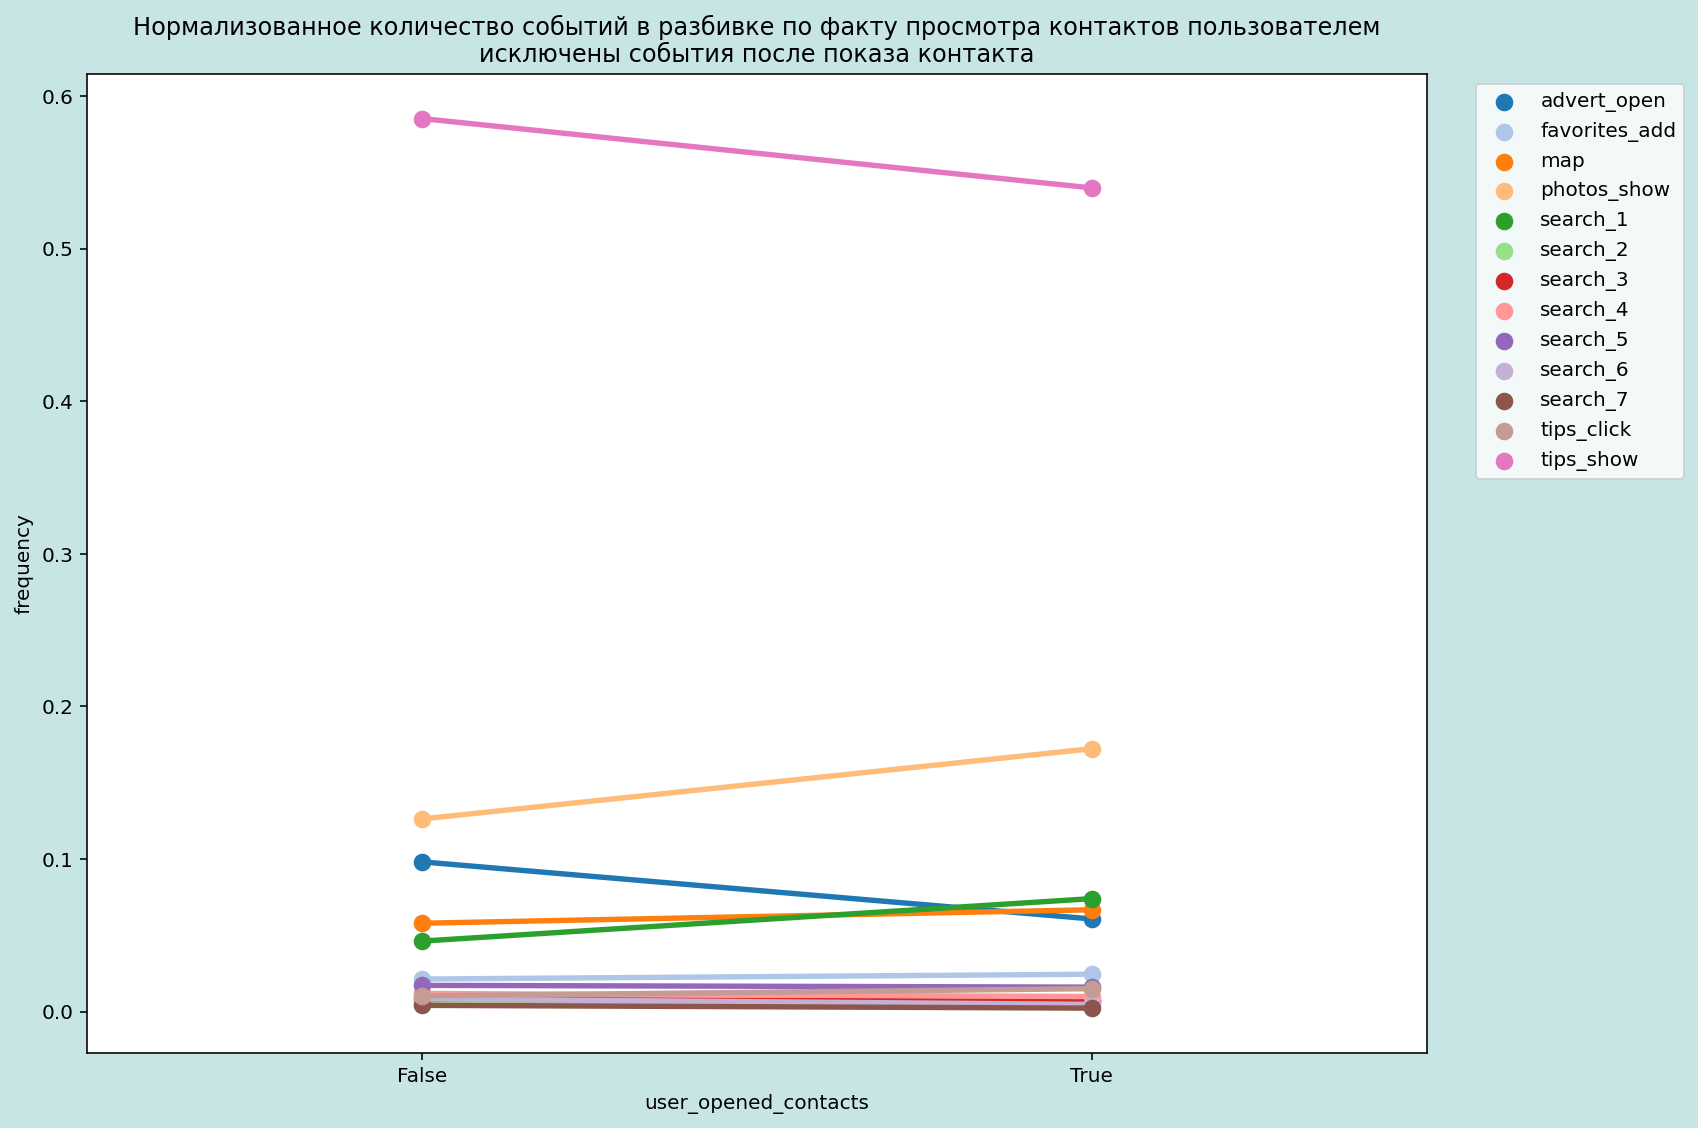

In [54]:
fig, ax = plt.subplots(figsize=(12, 9))
fig.patch.set_facecolor('#c8e5e6')
ax = sns.pointplot(
    hue="event_name", y="frequency",
    x='user_opened_contacts', palette='tab20',
    data=d1, 
       )

plt.title("Нормализованное количество событий в разбивке по факту просмотра контактов пользователем\nисключены события после показа контакта")
plt.legend(bbox_to_anchor=(1.2, 1))
;

В этом наборе данных событие tips_show происходит немного РЕЖЕ у тех, кто открывал контакты.

Еще раз укрупним нижнюю часть графика

''

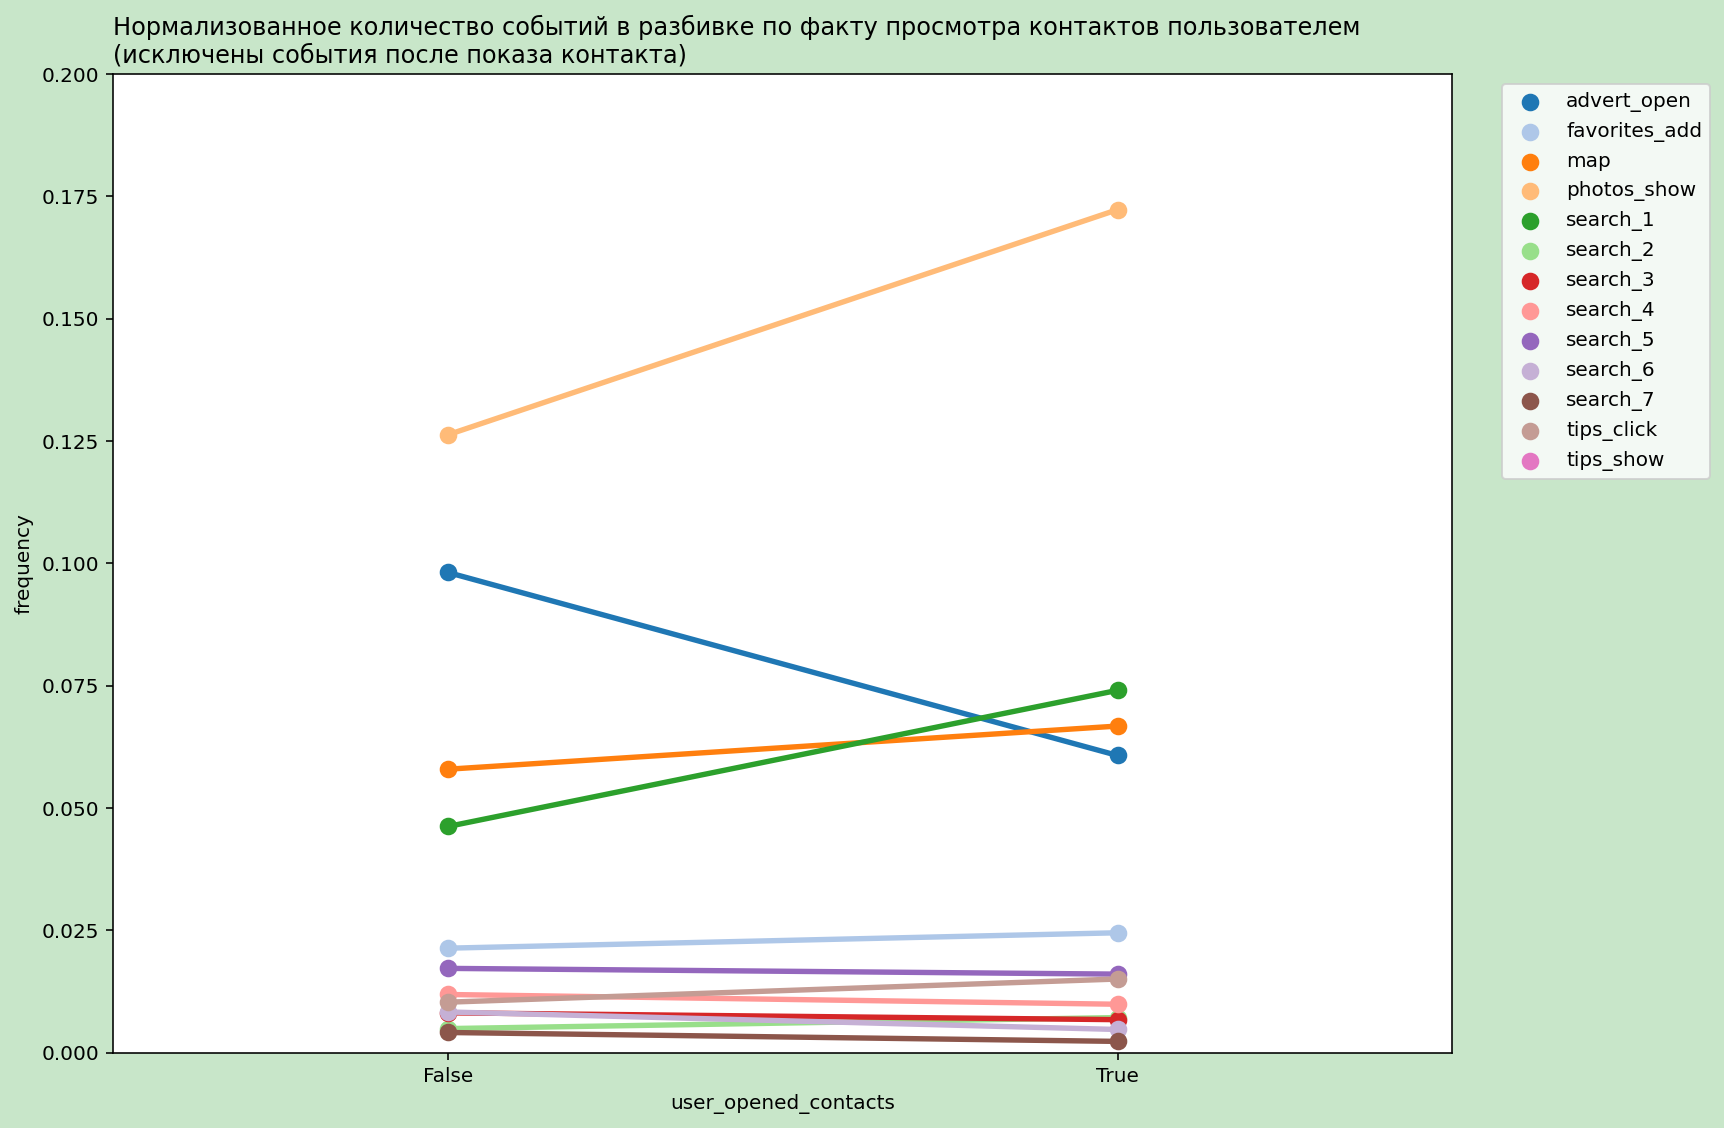

In [55]:
fig, ax = plt.subplots(figsize=(12, 9))
fig.patch.set_facecolor('#C8E6C9')
ax = sns.pointplot(
    hue="event_name", y="frequency",
    x='user_opened_contacts', palette='tab20',
    data=d1, 
       )
plt.ylim(0,0.2)
plt.title("Нормализованное количество событий в разбивке по факту просмотра контактов пользователем \n(исключены события после показа контакта)", loc='left')
plt.legend(bbox_to_anchor=(1.2, 1))
;

#### Вывод: 
- photos_show +5%
- search_1 +2%
- существенно падают tips_show, advert_open

### Определим последовательность действий, совпадающих с просмотром контактов

Конверсия не всегда происходит в первый день и соответственно не всегда в первую сессию.

In [56]:
observation_date = events['event_time'].max().date()
# рассчитываем максимально возможную дату привлечения
last_suitable_acquisition_date = observation_date - timedelta(days=13)
# исключаем пользователей, пришедших после максимальной даты привлечения
result_raw = profile.query('session1_dt <= @last_suitable_acquisition_date')

# находим размеры когорт
cohort_size = (
    result_raw.groupby('source')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
# таблица конверсии
result = (
    result_raw
    .pivot_table(index=['source'], columns='conversion_lt', values='user_id', aggfunc='nunique')
    .fillna(0)
    .merge(cohort_size, on='source', how='left').fillna(0)
)

# исключаем из результата все лайфтаймы, превышающие горизонт анализа и нулевой лайфтайм
result = result[list(range(0, 14))]

In [57]:
print ('Количество конверсий, по лайфтаймам')
display (result.head())

Количество конверсий, по лайфтаймам


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
source,,,,,,,,,,,,,,
google,118.0,6.0,3.0,2.0,5.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0
other,90.0,7.0,9.0,3.0,1.0,3.0,4.0,0.0,1.0,5.0,2.0,2.0,1.0,2.0
yandex,210.0,15.0,8.0,5.0,6.0,9.0,2.0,0.0,3.0,3.0,2.0,2.0,0.0,1.0


#### Определить, за какое время до совершения целевого события совершаются вспомогательные события

- Так как конверсия не всегда происходит в первую сессию. Поэтому проверять, какое действие наступает до, а какое после конверсии, буду, сгруппировав события по user_id
- Соответственно, мы получим большие временные разрывы между сессиями. Поэтому последовательность действий буду показывать не в секундах, а в шагах (какое по очереди действие относительно показа контактов)

Контакты открывали 23% пользователей. При этом 11% пользователей открывали их один раз. Считаю, это достаточно репрезентативная выборка для анализа последовательности действий.

In [58]:
sequence.groupby('user_id')['user_opened_contacts_count'].mean().value_counts(normalize=True).head()

0    0.771488
1    0.088516
2    0.043093
3    0.024691
4    0.016306
Name: user_opened_contacts_count, dtype: float64

In [59]:
data4 = sequence.query('user_opened_contacts_count == 1')
data4.shape

(6010, 13)

''

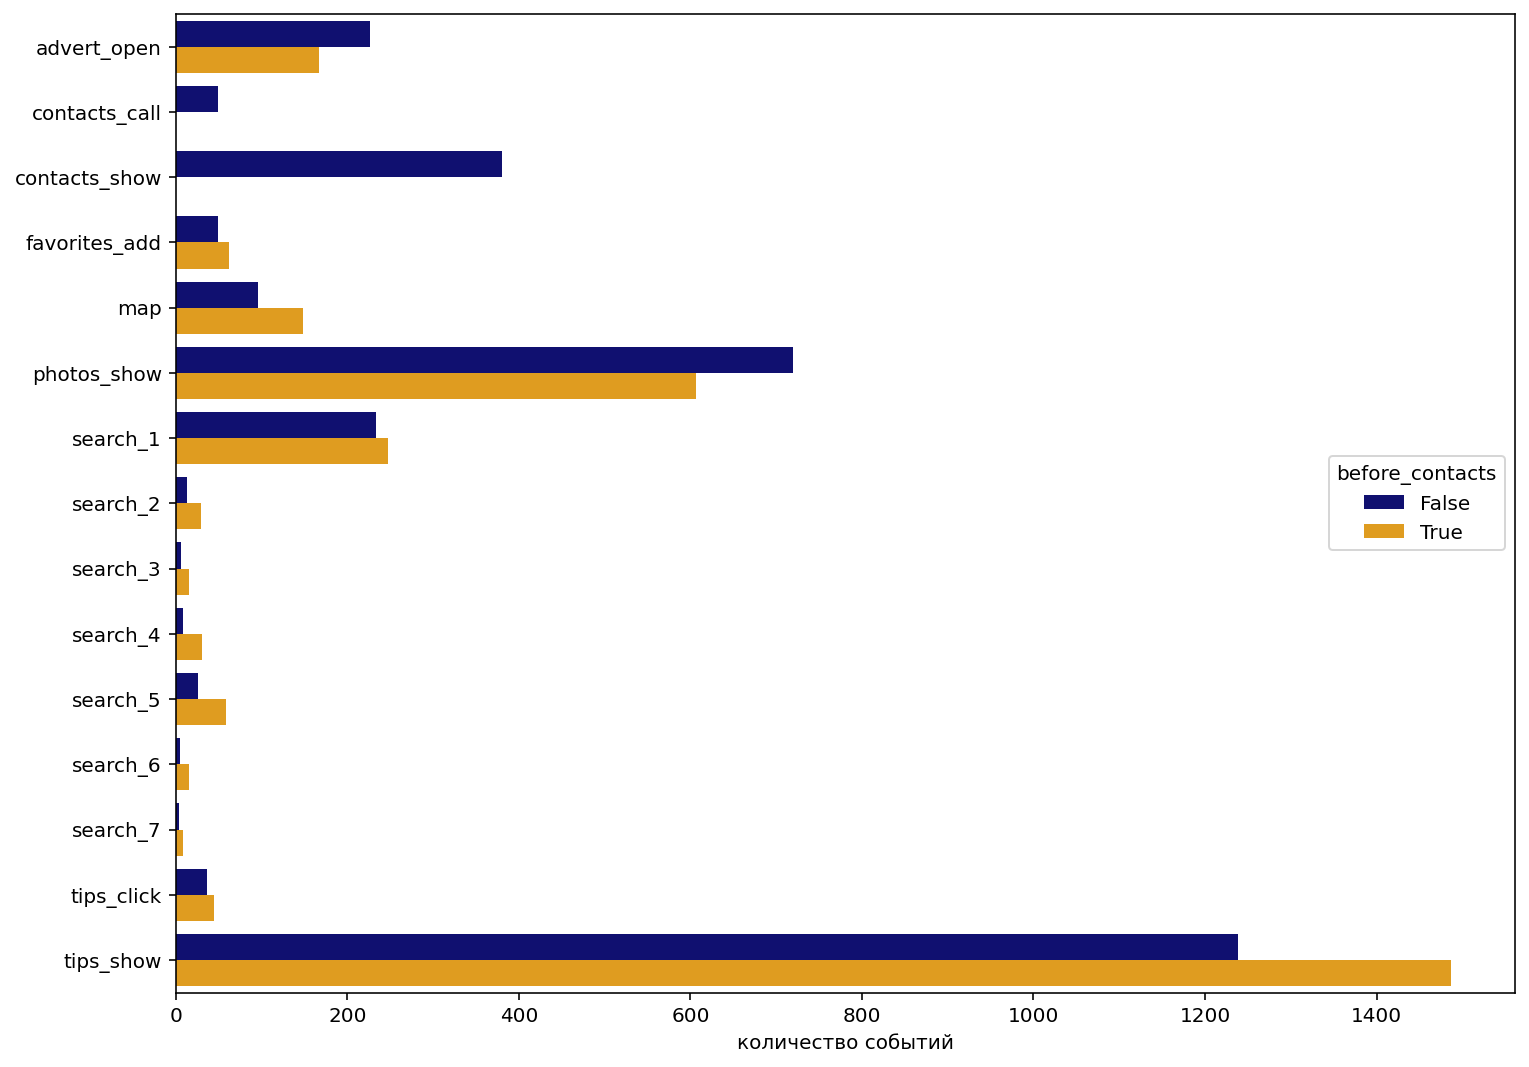

In [60]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.countplot(
    y="event_name", 
    hue="before_contacts", palette=['navy', 'orange'],
    data=sequence.query('user_opened_contacts_count == 1'),
    order = sorted(sequence['event_name'].unique()), ax=ax
    )
ax.set_xlabel('количество событий')
ax.set_ylabel('')
; 

- в этом наборе данных существенно чаще случаются ДО первого открытия контактов события map, advert_open, все search и tips_show
- но как мы видели раньше это не значит, что именно эти события отличают клиентов, которые открывают контакты. 


Сформируем набор данных с разметкой последовательности шагов относительно целевого действия. Целевое действие = 0, все что раньше - осчитывается обратным порядком, все что позже - нарастающим.

In [61]:
order = (sequence
              .query('user_opened_contacts_count == 1')
              [['user_id', 'event_time', 'event_name', 'contact_show_1st_time']])
order['step'] = order.groupby('user_id').cumcount() # разметим порядок шагов
contact_show_position = (
    order
    .query('event_name == "contacts_show"')[['user_id','step']]
    .rename(columns={'step':'contact_show_position'})) # найдем номер шага "показ контактов"
order = (
    order
    .merge(contact_show_position, on='user_id', how='left') # добавим номер шага "показ контактов" в набор данных
    # размечу шаги относительно целевого действия поменяю знак дельты, чтобы расположить слева направо на графике
    .assign(delta = lambda x: (x['contact_show_position'] - x['step']) * -1)    
)

order['legend'] = ['before' if i < 0 else 'after' for i in order['delta']]

order.head(5)

,user_id,event_time,event_name,contact_show_1st_time,step,contact_show_position,delta,legend
0,00753c79-ea81-4456-acd0-a47a23ca2fb9,2019-10-20 14:57:06,contacts_show,2019-10-20 14:57:06,0,0,0,after
1,00753c79-ea81-4456-acd0-a47a23ca2fb9,2019-10-22 19:59:00,photos_show,2019-10-20 14:57:06,1,0,1,after
2,00753c79-ea81-4456-acd0-a47a23ca2fb9,2019-10-22 20:20:58,photos_show,2019-10-20 14:57:06,2,0,2,after
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,2019-10-22 20:23:24,photos_show,2019-10-20 14:57:06,3,0,3,after
4,00753c79-ea81-4456-acd0-a47a23ca2fb9,2019-10-22 20:24:57,photos_show,2019-10-20 14:57:06,4,0,4,after


В целом если построить график плотности распределения событий вокруг шага contacts_show, я не вижу какой-то четкой последовательности для всех событий, кроме contacts_call. Оно, как и следовало ожидать, случается четко после contacts_show и это видно на графике. Т.е. в целом такая логика поиска очередности событий работает, но возможно в событиях в принципе нет явной последовательности. 

''

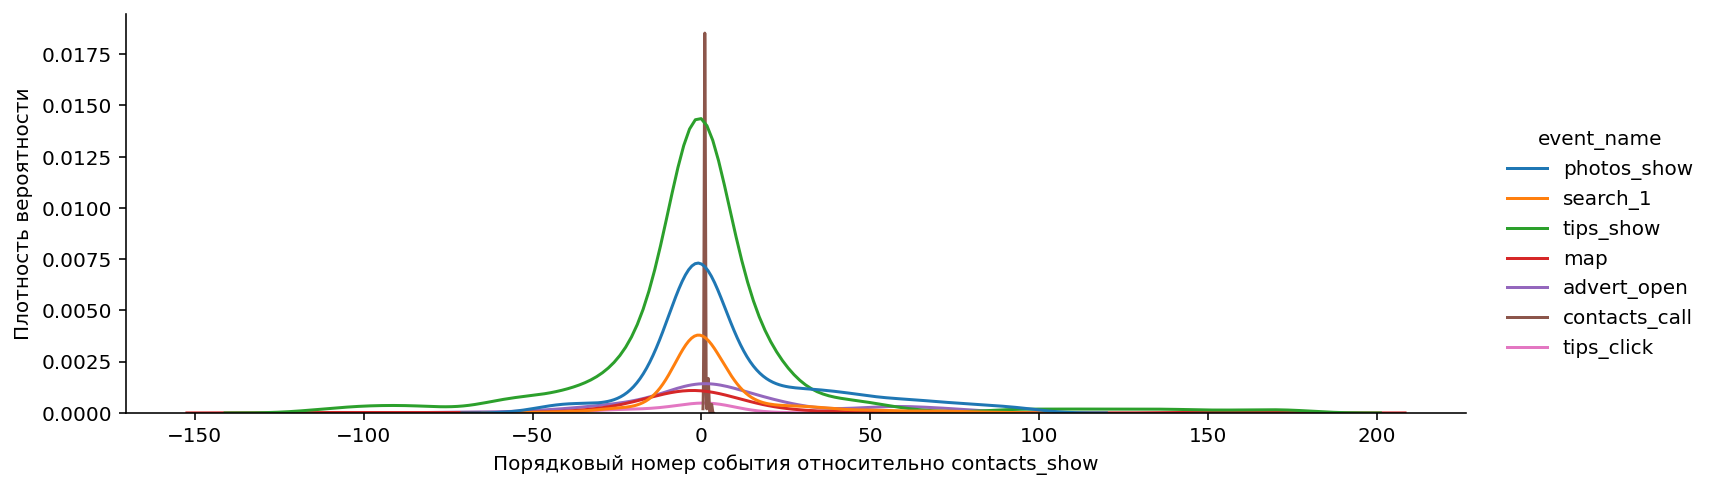

In [62]:
g = sns.displot(
    order.query('event_name in ("photos_show", "search_1", "tips_show", "tips_click", "map", "advert_open","contacts_call")'), 
    x='delta', hue='event_name', kind='kde', fill=False,
    height=3.5, aspect=3
)
g.set_axis_labels("Порядковый номер события относительно contacts_show", "Плотность вероятности")
;

Можно было бы предположить, что мы не видим вариаций т.к. большинство последовательностей короткое и соответственно вариации прячутся ближе к центру графика. Но даже если увеличить до плюс-минус пяти событий вокруг contacts_show, паттерна не видно. Кроме, как и ожидается, contacts_call.

''

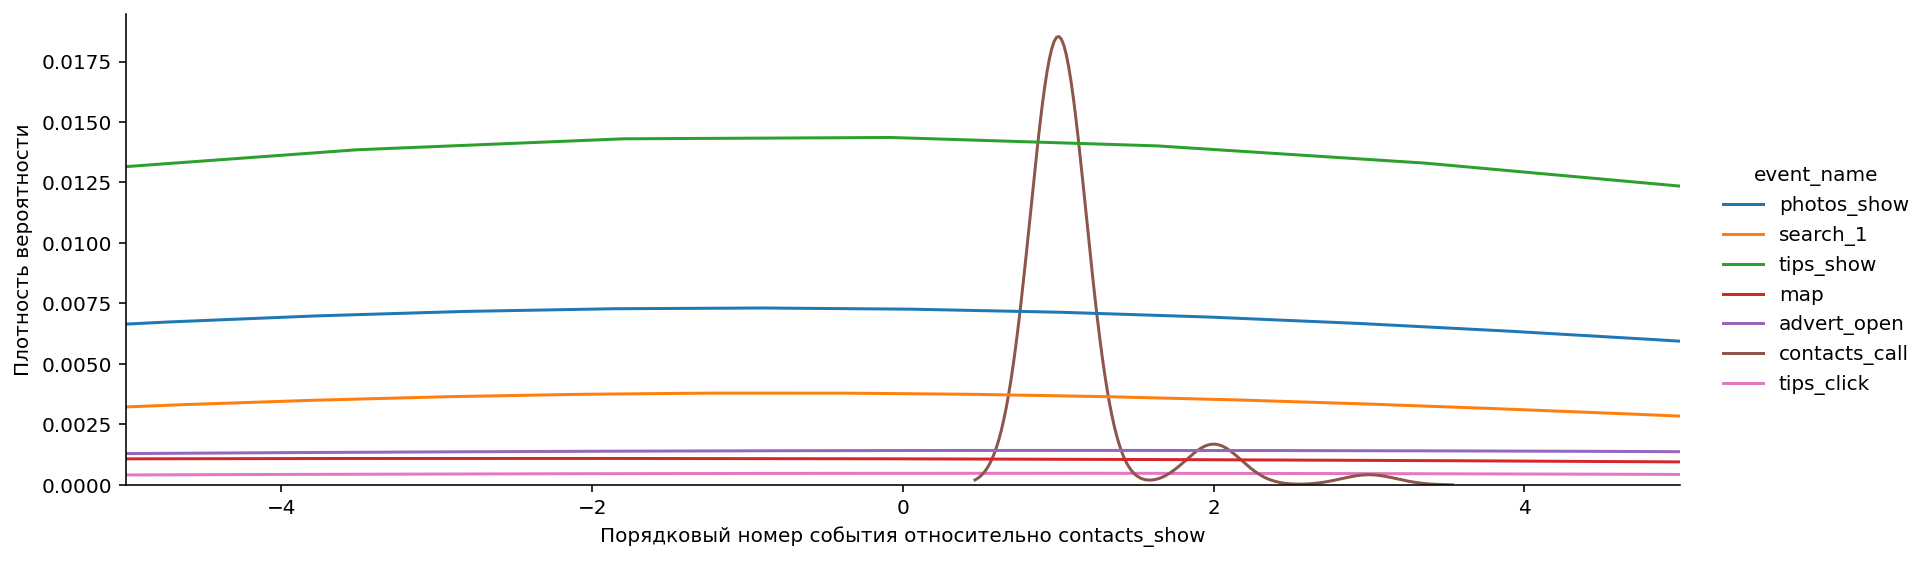

In [63]:
g = sns.displot(
    order.query('event_name in ("photos_show", "search_1", "tips_show", "tips_click", "map", "advert_open", "contacts_call")'), 
    x='delta', hue='event_name', kind='kde', fill=False,
    height=4, aspect=3
)
g.set(xlim=(-5, 5))
g.set_axis_labels("Порядковый номер события относительно contacts_show", "Плотность вероятности")
;

Построим гистограммы очередности событий с детальностью до одного события.

In [64]:
#определю функцию для построения гистограмм распределения событий относительно показа контактов
# функция принимает кортеж названий событий для визуализации на отдельных графиках и цвет событий с признаком "before" показа контактов
def goal_viz(event_tuple, color):
    print ('Количество событий каждого типа, сгруппированных по порядковому номеру события \nдо и после события contact_show')
    print ('Вертикальная линия = медиана порядкового номера событий')
        
    df = order.query('event_name in @event_tuple')
    for i in df['event_name'].unique():
        fig, ax = plt.subplots(figsize=(12, 6.5))
        sns.histplot(
            data=df.query('event_name == @i'),
            x='delta' , multiple="stack", hue='legend',  hue_order=['before', 'after'],
            legend='legend', linewidth=0.2, alpha=0.9, bins=range(-80,80,1),
            palette=({'after':'#7B1FA2', 'before':color}) 
        )
        ax.axvline(df.query('event_name == @i')['delta'].median(), color='red', 
                   label='Медиана', linestyle='dashed', linewidth=3, alpha=0.7)
        ax.set_xlabel("Порядковый номер события относительно contacts_show")
        ax.set_ylabel("Количество событий")
        ax.set_title(str(i) + '; Медиана = ' + str(df.query('event_name == @i')['delta'].median()))
        ax.set(xlim=(-80,80))
        plt.legend()
    ;      

Проверим отобранные признаки 'photos_show', 'search_1'

Количество событий каждого типа, сгруппированных по порядковому номеру события 
до и после события contact_show
Вертикальная линия = медиана порядкового номера событий


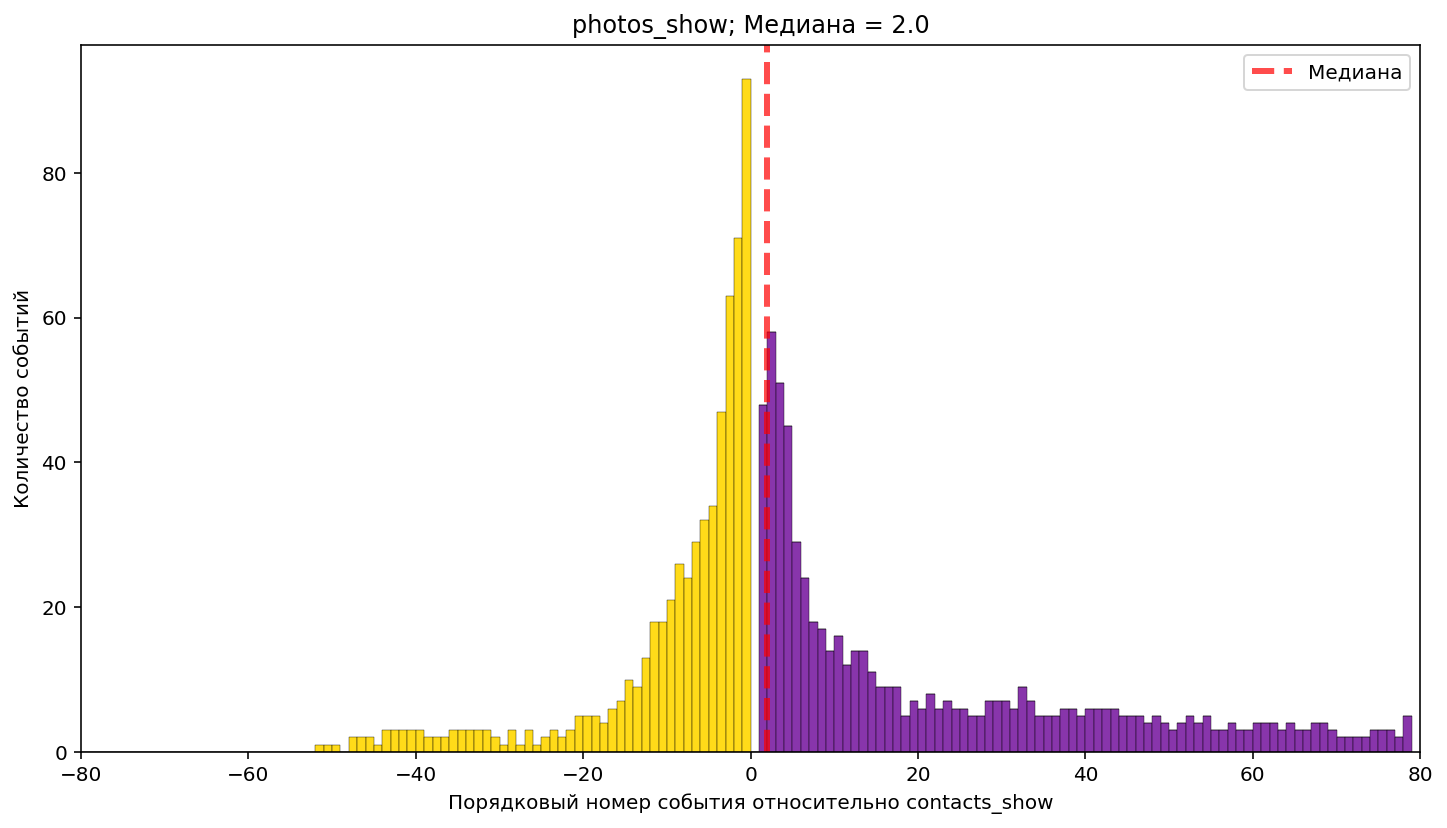

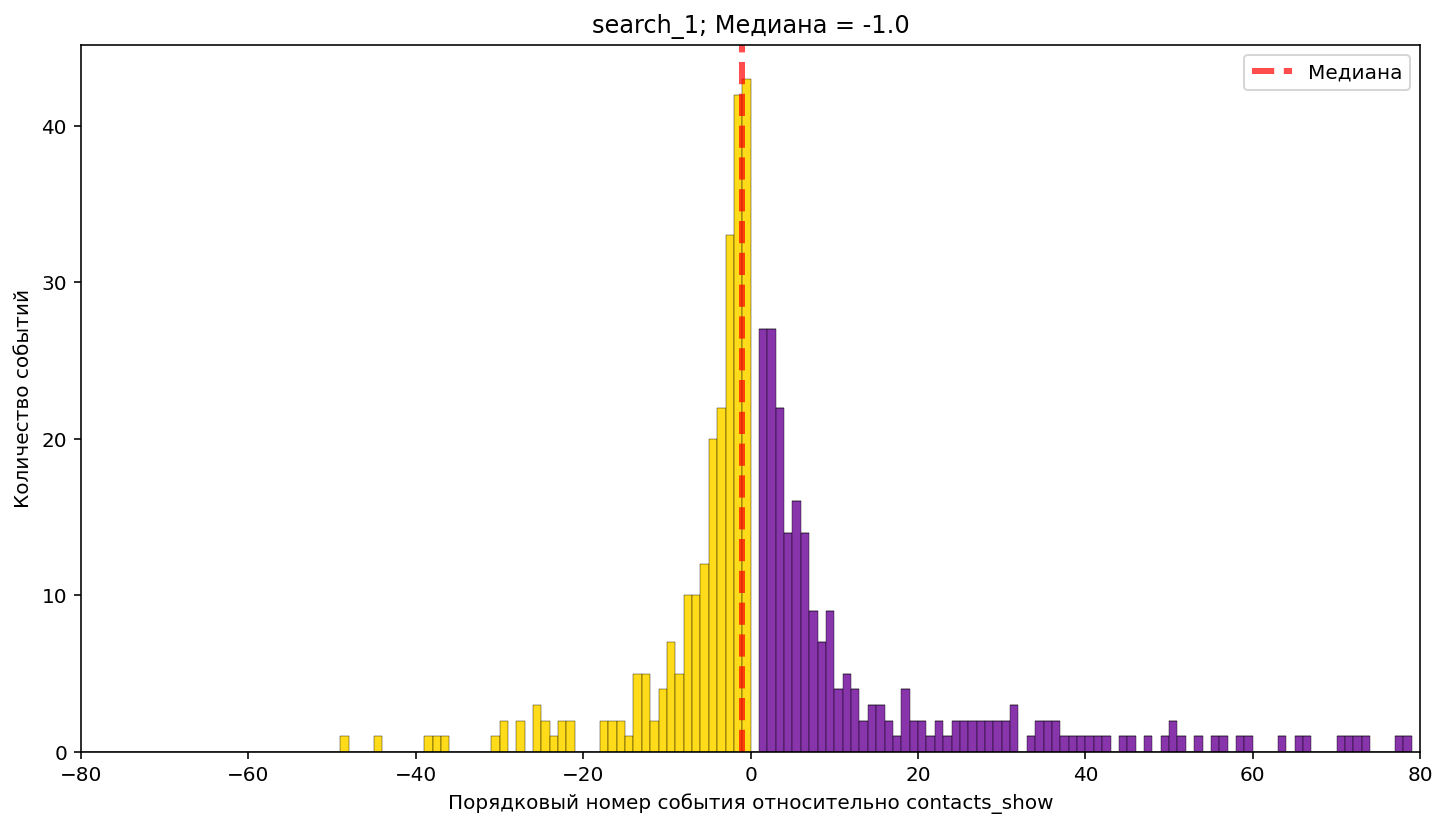

In [65]:
goal_viz(('photos_show', 'search_1'), 'gold')

In [66]:
# order['event_name'].unique()

Количество событий каждого типа, сгруппированных по порядковому номеру события 
до и после события contact_show
Вертикальная линия = медиана порядкового номера событий


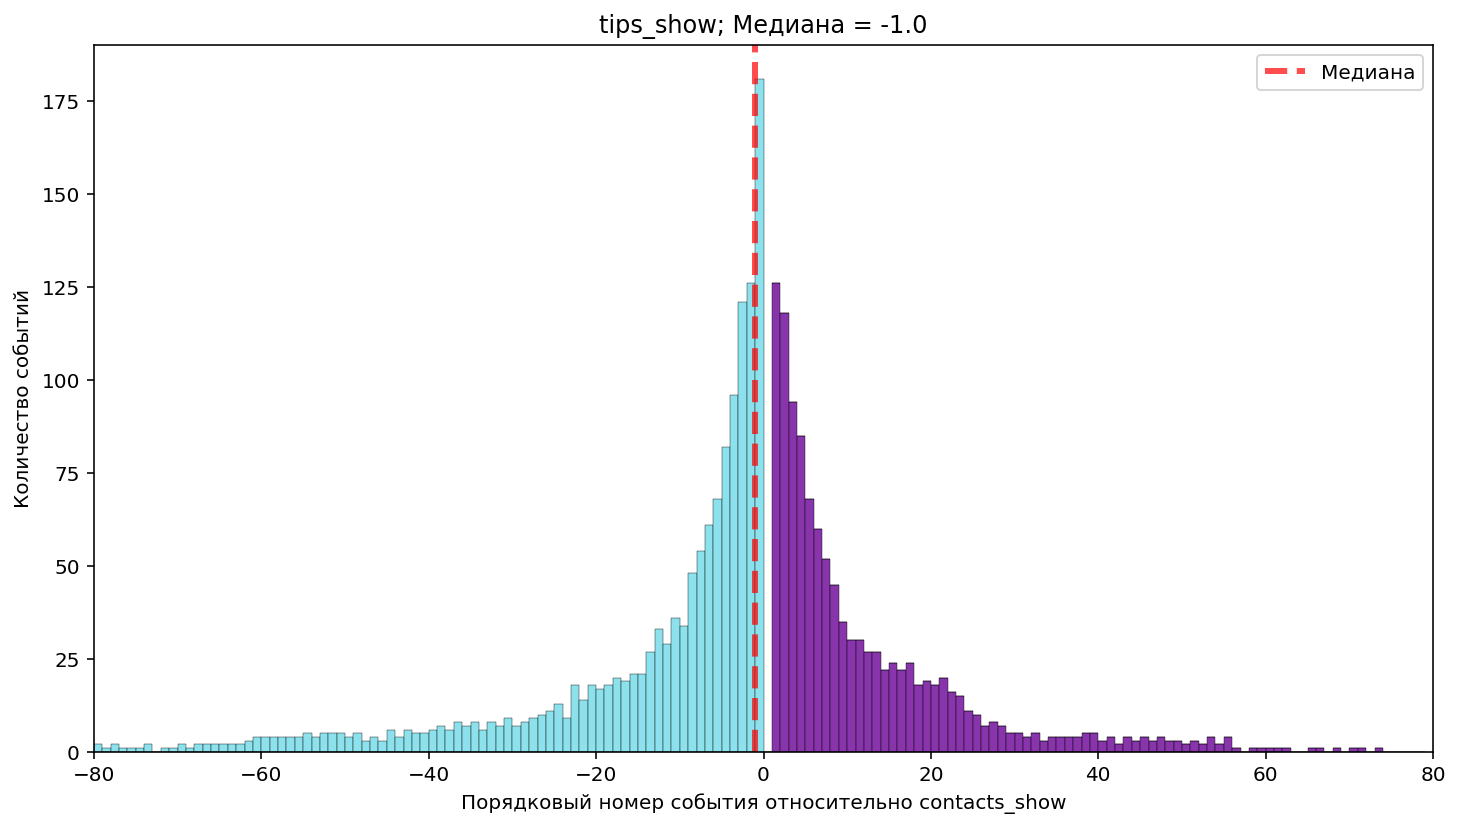

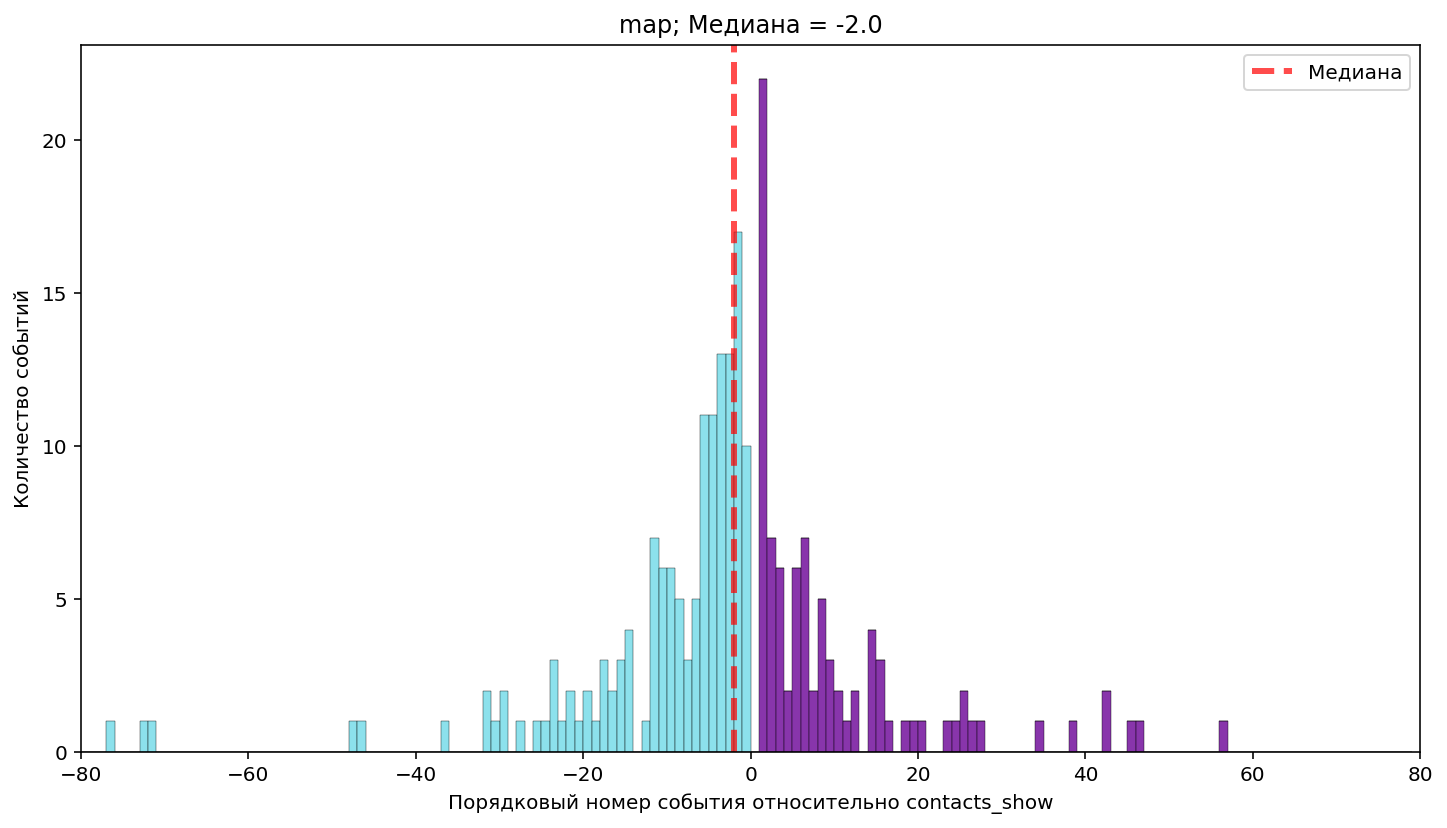

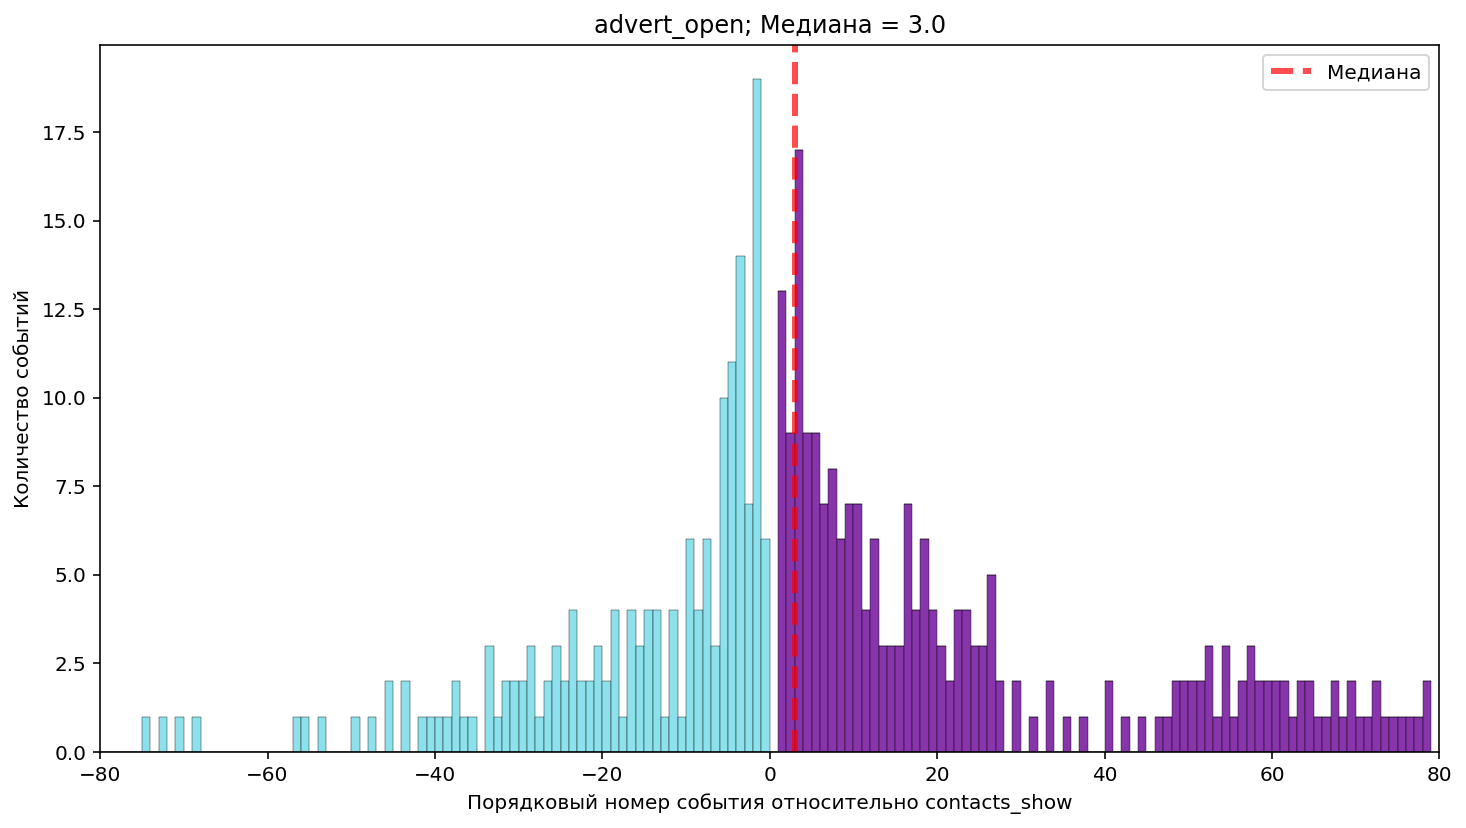

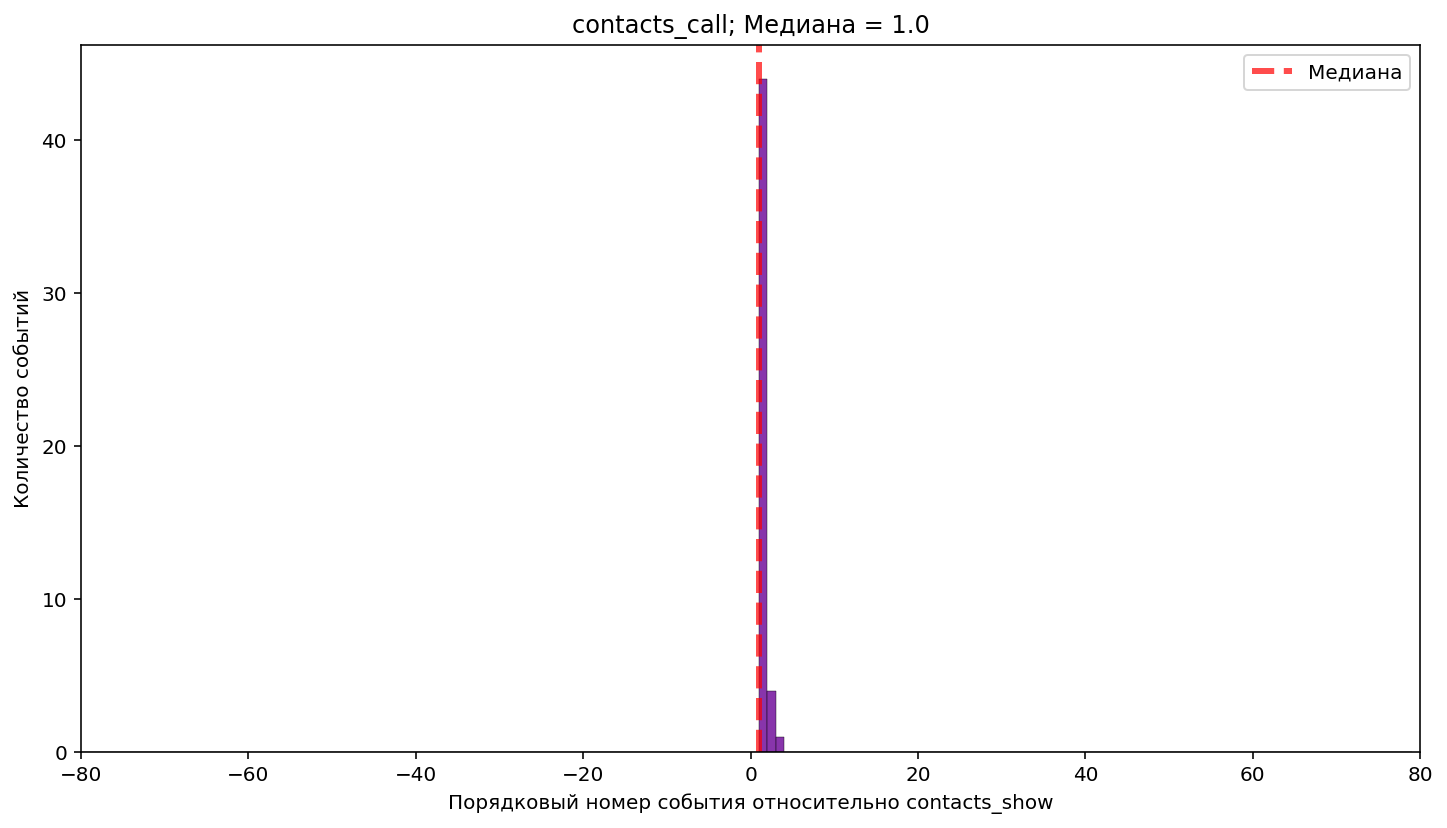

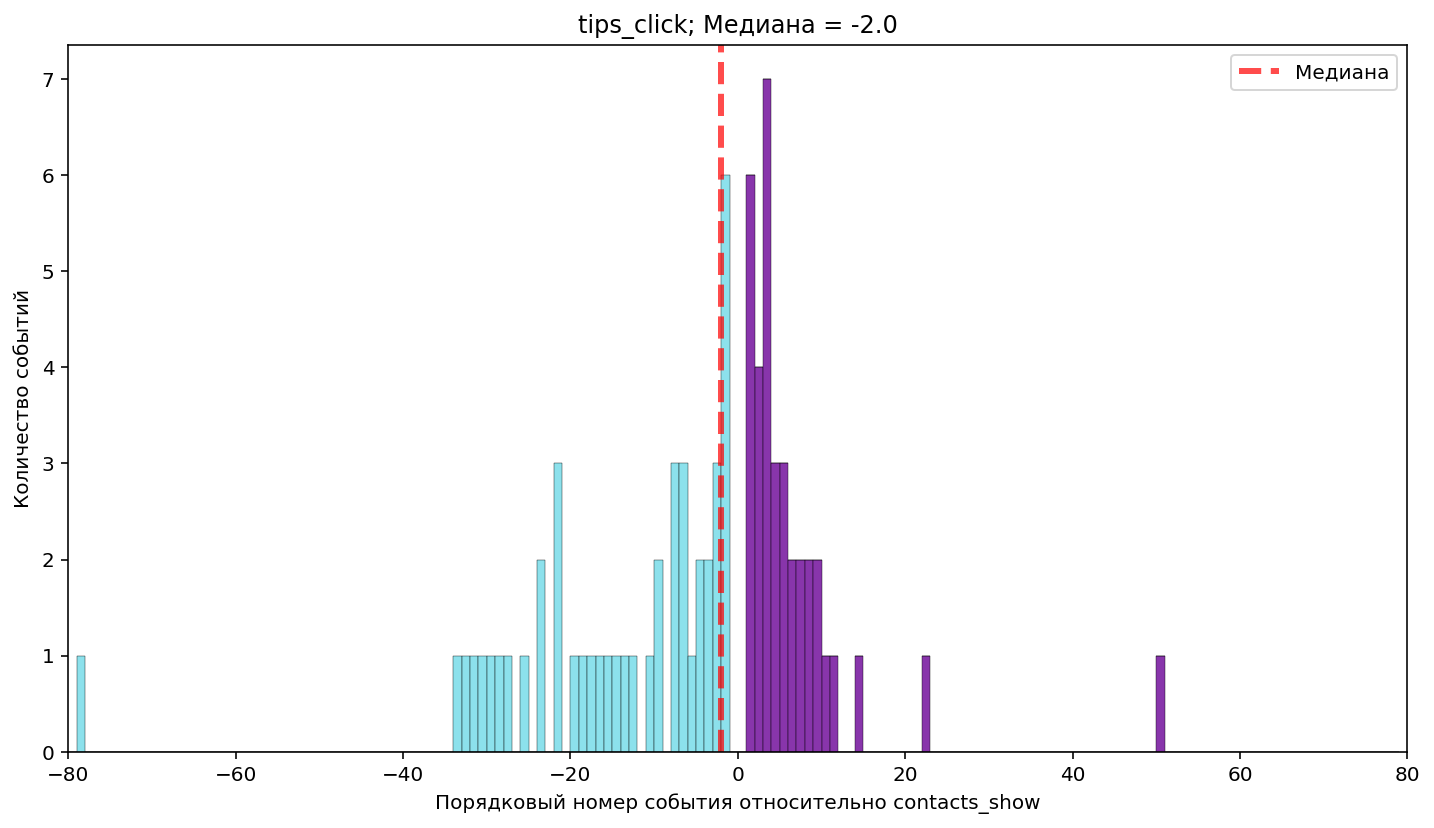

In [67]:
goal_viz(('tips_show', 'tips_click', 'map', 'advert_open', 'contacts_call'), '#80DEEA')

#### Выводы

- события photos_show', 'search_1' 
    - начинаются достаточно поздно (50 событий до contacts_show, в то время как события tips_show, advert_open - за 80 событий до contacts_show
    - показывают явный пик около contacts_show
    
    - медианный порядковый номер события search_1 = -1, т.е. оно чаще случается ДО события contacts_show
    - медианный порядковый номер события photos_show = 2, т.е. оно чаще случается ПОСЛЕ события contacts_show

- события tips_show, map
    - начинаются существенно раньше (порядка 80 событий до contacts_show)
    - показывают явный пик около contacts_show
    - медианный порядковый номер события map = -2, т.е. оно чаще случается ДО события contacts_show
    - медианный порядковый номер события tips_show = -1, т.е. оно чаще случается ДО события contacts_show
    - медианный порядковый номер события photos_show = 2, т.е. оно чаще случается ПОСЛЕ события contacts_show
    
- событие contacts_call всегда случается после события contacts_show

### Проверим статистические гипотезы

#### Конверсия различается для групп "tips_show & tips_click" и "tips_show only"

Группы:
- пользователь совершил событие tips_show, но не совершал событие tips_click
- пользователь совершил события tips_show И tips_click

Н0: конверсия для этих групп не отличается

Н1: конверсия отличается

Для проверки использую z-критерий по долям

Подготовим выборки

In [68]:
sample = (
    sequence
    .query('event_name in ("tips_show", "tips_click")')
    .pivot_table(index=['user_id', 'user_opened_contacts'], columns='event_name', values = 'session_id', aggfunc='count')
    .fillna(0).reset_index()
    .assign(group = 'other') 
)

sample.loc[(sample['tips_show'] > 0) & (sample['tips_click'] > 0), 'group'] = 'show_click'
sample.loc[(sample['tips_show'] > 0) & (sample['tips_click'] == 0), 'group'] = 'show'

sample.sample(5)

event_name,user_id,user_opened_contacts,tips_click,tips_show,group
911,54fbc7eb-a4d7-4a14-8f36-441cca9577a7,False,0.0,21.0,show
2270,cfb8a35a-9c5e-41af-9b07-090ead891dd0,False,0.0,2.0,show
903,543f1bc6-c773-46d1-af50-a6d8eaa3a620,False,0.0,1.0,show
1983,b5743696-eaa7-42fd-966c-f7c87104d532,False,0.0,3.0,show
752,4541b83e-7927-4679-aa6b-5ee0e97e8aad,False,0.0,2.0,show


- Группа show_click небольшая, всего 297 пользователей
- Обнаружились пользователи, для которых есть события 'tips_click' но при этом нет событий tips_show

In [69]:
sample['group'].value_counts()

show          2504
show_click     297
other           25
Name: group, dtype: int64

Это не ошибка в расчетах, такая же картина и в исходном датасете (если посчитать все события для пользователей из группы 'other' набора данных sample)

In [70]:
events.query('user_id in ("15b31b5a-e8eb-4f5d-b7fc-80214e60abca", "e6160ded-5b2d-4890-aa6f-9d5956e9a156",\
             "0edcd514-9e76-41dd-9d14-c7e35bfcca78")')['event_name'].value_counts()

tips_click       19
contacts_show     5
map               1
favorites_add     1
Name: event_name, dtype: int64

Посчитаем conversion rate для целевых групп и для всего набора данных

In [71]:
sample.groupby('group')['user_opened_contacts'].mean()

group
other         0.360000
show          0.169728
show_click    0.306397
Name: user_opened_contacts, dtype: float64

In [94]:
profile['user_opened_contacts'].mean()

0.22851153039832284

Согласно калькулятору A/B тестов https://www.optimizely.com/sample-size-calculator/?conversion=2.2&effect=25&significance=95, при базовой конверсии в 22.9%, чтобы достоверно отследить относительные изменения в конверсии на 25%, нам нужна выборка в 540 событий. Наш набор данных немного меньше. Тем не менее, продолжу.

In [73]:
from statsmodels.stats.weightstats import ztest as ztest
alpha = 0.01
sample_1 = sample.query('group == "show"')['user_opened_contacts']
sample_2 = sample.query('group == "show_click"')['user_opened_contacts']

tstat, pval = ztest(sample_1, sample_2, 0)

print('Конверсия группы "tips_show & tips_click": ', sample_1.mean() )
print('Конверсия группы "tips_show": ', sample_2.mean() )
print('Нулевая гипотеза: средняя конверсия для двух групп не отличается')
print('Альтернативная гипотеза: средняя конверсия отличается')
print('Alpha = ', alpha)

print('p-значение: ', pval)

if pval < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")   

Конверсия группы "tips_show & tips_click":  0.16972843450479233
Конверсия группы "tips_show":  0.3063973063973064
Нулевая гипотеза: средняя конверсия для двух групп не отличается
Альтернативная гипотеза: средняя конверсия отличается
Alpha =  0.01
p-значение:  7.622720539007373e-09
Отвергаем нулевую гипотезу


##### Вывод: конверсия для групп для групп "tips_show & tips_click" и "tips_show only" статистически достоверно различается даже при α = 0.01

#### Проверить свою статистическую гипотезу 

Проверю гипотезу, что конверсия у пользователей, пришедших через Яндекс отличается от пришедших через Google

In [74]:
from statsmodels.stats.weightstats import ztest as ztest
alpha = 0.05
sample_1 = profile.query('source == "yandex"')['user_opened_contacts']
sample_2 = profile.query('source == "google"')['user_opened_contacts']

tstat, pval = ztest(sample_1, sample_2, 0)

print('Конверсия по источнику Yandex: ', sample_1.mean() )
print('Конверсия по источнику Google: ', sample_2.mean() )
print('Нулевая гипотеза: средняя конверсия для двух групп не отличается')
print('Альтернативная гипотеза: средняя конверсия отличается')
print('Alpha = ', alpha)

print('p-значение: ', pval)

if pval < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")   

Конверсия по источнику Yandex:  0.24715615305067218
Конверсия по источнику Google:  0.24357838795394154
Нулевая гипотеза: средняя конверсия для двух групп не отличается
Альтернативная гипотеза: средняя конверсия отличается
Alpha =  0.05
p-значение:  0.824486610228157
Не получилось отвергнуть нулевую гипотезу


##### Вывод: не можем утверждать, что конверсия по источникам Yandex и Google отличается статистически достоверно.

## Выводы

### Качество данных
- Набор данных небольшой (74 тысячи записей, охватывающий 28 дней)
- В целом данные качественные, без явных аномалий
- предположу что воронка может грубо соответствовать событиям, упорядоченным по количеству
- Распределение по источникам: Яндекс почти половина, Гугл и остальные - поровну

### Удержание: 
- удержание существенно выше для клиентов, которые смотрели контакты
- не видно существенной разницы по дате когорты
- не видно существенной разницы по источнику привлечения
- **возможно, данных недостаточно для анализа:** предположу, что для приложения, в котором пользователи продают / покупают вещи может иметь смысл рассматривать более длинный временной промежуток для анализа удержания (пользователи могут возвращаться раз в месяц или даже реже)

КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ:
- Новых пользователей немного (порядка 150 в день), и при этом их количество уменьшается. Количество действий в день коррелирует с количеством новых пользователей. Соответственно, пользователи не очень часто возвращаются либо возвращаются реже чем раз в 28 дней
- DAU примерно в 1,5 раза больше количества новых пользователей в день


### Конверсия:
- 77% пользователей ни разу не открывали контакты
- конверсия стабильно отличается по источникам: 
    - лучший результат - Yandex, следующий - Google, на третьем месте - остальные источники (конверсия по источнику Yandex:  24,7%, по источнику Google:  24,3%)
    - однако мы не можем утверждать, что это отличие статистически достоверно
- конверсия групп "tips_show & tips_click" = 17% и статистически достоверно меньше конверсии группы "tips_show" ТОЛЬКО, которая равна 30,6%

### Последовательность действий

- события tips_show, map
    - начинаются довольно рано (порядка 80 событий до contacts_show)
    - показывают явный пик около contacts_show
    - медианный порядковый номер события map = -2, т.е. оно чаще случается ДО события contacts_show
    - медианный порядковый номер события tips_show = -1, т.е. оно чаще случается ДО события contacts_show
    - медианный порядковый номер события photos_show = 2, т.е. оно чаще случается ПОСЛЕ события contacts_show
 
 
- события photos_show, search_1 
    - относительно чаще случаются у пользователей, которые открывали контакты
    - начинаются достаточно поздно (50 событий до contacts_show)
    - показывают явный пик около contacts_show
    - медианный порядковый номер события search_1 = -1, т.е. оно чаще случается ДО события contacts_show
    - медианный порядковый номер события photos_show = 2, т.е. оно чаще случается ПОСЛЕ события contacts_show
 
 
- событие contacts_call 
    - не случается без события contacts_show 
    - всегда случается после события contacts_show
    - и это логично, чтобы позвонить сначала нужно увидеть контакт )
    
---
Не могу сделать однозначных выводов о последовательности действий, предшествующих событию contacts_show, так как события распределены относительно симметрично относительно contacts_show.


### Рекомендации

- для выводов об удержании и конверсии имеет смысл анализировать более длинный временной промежуток (пользователи могут возвращаться после длинного перерыва)

- для выводов о последовательности действий имеет смысл проанализировать более крупный набор методами машинного обучения. (сейчас в наборе данных всего 4293 пользователя, из них только 981 открывали контакты)

- Если пользователи возвращаются редко - возможно, они в основном продают вещи через приложение.Соответственно, потенциал к развитию может быть в том, чтобы пользователи начали рассматривать приложение как платформу не только для продажи, но и для покупок, и соответственно возвращались для поиска интересных предложений.
    
